## Starting Point

Neural Networks are excellent function approximators, so in a data rich world such as finance it would seem possible to train neural networks to learn these option pricing function. The question is **why** would we do this, when we have perfectly good and well established computer models that can already do it.

## Terminology
* **Option** a financial contract with a value contingent on some initial terms and how the financial markets move during the life of the contract.
* **Model** a mathematical algorithm that can determine the value of a specific type of option.
* **Neural Network** or **NN** A function approximator based on matrix manipulation that can be trained to find an approximate general form of a function given sufficient examples of input parameters and corresponding result(s).

## Motivation

There are many simple options that can be modelled *closed form*, i.e. with an equation, where we pass the valuation details and with relatively little compute cost and delay we are given a reliable valuation. 

However there are more complex options that have no such *closed form* as they have complex features. Typically these are *path dependent*, as in it matters how their valuation parameter change over time, and to solve these a very common solution is to run many simulations of how the valuation parameters will evolve in the future. We then valuation the option on all of these simulated future paths. It is then possible to combine the results of the simulations and establish the optimal price of the option. Where the *optimal* price is the price that would compensate the seller for entering into a contract where there is a likelihood they will have to pay out to tye buyer.

In these path dependent case, the number of simulations needed to get an accurate price can be very high. As such the compute costs is high and the time to run the calculation is also long, relative to the *closed form* cases.

Typically when selling (offering) options, the seller will make a market, by pricing many different terms and will also respond to **r**equest **f**or **q**uotes (RFQs) during the trading day. This can amount to a very significant number of calculations and as such significant compute costs eating into margins. In addition the time it can take to quite may be seen as client differentiating if it can be done more quickly than other sellers. In addition once a trade is done, the seller must re-value the trade as the market moves so they can understand their profit and loss as well as [hedge](https://www.investopedia.com/terms/h/hedge.asp) their risks. Again, this can involve a significant number of costly calculations.

## Hypothesis  

A neural network is slow to train but quick when making a prediction, as it is in essence a simple matrix multiplication. So the hypothesis we look at here is:
> Can a neural network be trained to estimate the financial option contract pay-offs and be accurate enough to have commercial use.
* If they can be trained is it more cost effective to train a neural network than to run it on demand as needed
* and is the neural network quicker when predicting than the equivalent direct model call.
* Then finally, are there viable commercial uses, proprietary trading, client valuations and approved in regulatory settings.

## Considerations

* Normal Day to Day operations generate many option valuations, which if captured this data could be used as training data
* Such, Day to Day data may not cover all possible scenarios, so might need to be augmented by creating specific training data
* Some complex financial options have many features, and feature spaces of 50 to 100 would require a significant amount of training data to ensure coverage in high such dimensions.
* Neural networks will always make a prediction, even when untrained.
* From a client and regulatory point of view [expandability](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) is a challenge as the seller may not be able to show why a certain price was given.
* As the markets move, the neural will need re-training, however this can be done by re-training the existing neural network with additional data, but it needs to be monitored.
* Accuracy will not be consistent, it will depend on where the prediction falls in feature space and how well covered that region is.
* Availability of data, the sellers organization will need to be set-up to value data and its monetization. Otherwise the cost of souring the data and changing the organization mindset will be prohibitive.

## Approach

Train a Neural Net to predict a:

1. Simple closed form model. This is not a target use case but is a first step in the proof.
2. Simple closed form model, with a simulated barrier condition to see how the NN behaves with step changes in price
3. Path dependent option with a small feature space.
4. Extrapolate the results to consider
   1. Data demands to train the neural network
   2. Relative cost of compute, on-demand vs trained neural network
   3. Relative speed of pricing 
   4. Pricing stability and accuracy
   5. Operational challenges and re-training
   6. Client concerns
   7. Seller concerns
   8. Regulatory concerns
   9. Go, No-Go on continuing the experiment with a high feature NN or 50+ dimensions in feature space.


In [1]:
#
# General Python utilities and imports.
#
import inspect
import math
import sys
from dataclasses import dataclass
from typing import Final
from typing import Tuple, List, Union, Callable
from functools import partial
from enum import Enum

In [175]:
#
# Some set-up for the NN environment, for this we are using TensorFlow and Keras.
#
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import PReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib  # part of sklearn

# We want high accuracy for our regressions, slower then float-32, but necessary for this use case.
tf.keras.backend.set_floatx('float64')

# We use the XG Boost library for the regression.
import xgboost as xgb


In [3]:
#
# This is so we can visualize results
#
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## Simple Closed Form Model

Our [closed form](https://en.wikipedia.org/wiki/Closed-form_expression) model is the [Black Scholes](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) option model. This will allow us to show the work flow and highlight the challenges with the approach.

The specific model implementation below is arbitrary, it is just a means to show how the neural network can learn a function of the same order of magnitude of complexity as a simple option contract.

The model also takes an function that inspects the price, volatility and Time to maturity and *optionally* modifies the price if it hit a condition in terms of price, volatility and time. This is to allow us to model the case where the option price has abrupt changes rather than smooth ones. Abrupt changes will be more of a challenge for the model to capture. We do this as many commercially traded options do have such [barrier](https://en.wikipedia.org/wiki/Barrier_option) features (knock-in, knock-out, up-and-out etc.)

This naive implementation will run on the CPU only. There are techniques to utilize all CPU cores, however these vary by language C++, Python etc and are non trivial to get right and distract from the problem at hand. As we will see later using tensorflow, it is possible to create language independent computation graphs that can fully utilize the GPU(s) available. This is s significant step up as a contemporary GPU will have approx. 10'000 cores compared to a CPU with approx 16 cores.

In [4]:
@dataclass(frozen=True)
class BSConstants:
    call: Final[int] = 1
    put: Final[int] = 0
    american: Final[int] = 1
    european: Final[int] = 0
    price: Final[int] = 0
    delta: Final[int] = 1


def black_scholes_model(
    S: float,
    K: float,
    T: float,
    r: float,
    v: float,
    o: int = BSConstants.call,
    barrier: Callable[[float, float, float, float], float] = None,
    with_delta: bool = False,
) -> Tuple[float, float]:
    """
    Implementation of Black Scholes model.

    Trivial example to demonstrate proof of concept for fitting an option pricing model
    with a neural network.

    Args:
        S (float): Spot
        K (float): Strike
        T (float): Time to maturity
        r (float): Risk-free rate
        v (float): Underlying volatility
        o (int): Option type, call = 0 or put = 1
        barrier (Callable[[float, float, float, float], float]): A callable that takes price, spot, volatility, and time
            and returns a modified price if a certain volatility and/or time barrier has been hit
        with_delta (bool): If True, calculate option delta; otherwise, return None for delta

    Returns:
        Tuple[float, float]: Option Price, Delta
    """
    price: float = None
    delta: float = None

    d1 = (np.log(S / K) + (r + 0.5 * v**2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v**2) * T) / (v * np.sqrt(T))

    if o == BSConstants.call:
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        if with_delta:
            delta = norm.cdf(d1)
    elif o == BSConstants.put:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        if with_delta:
            delta = float(1) - norm.cdf(d1)
    else:
        assert False, "Option must be call=0 or put=1"

    if barrier is not None:
        # delta not valid with our simple barrier override
        return (barrier(price, S, v, T), None)

    return (price, delta)

## Pricing Scenarios

In the real use case we will collect the back history  [RFQ (request for quote)](https://www.investopedia.com/terms/r/request-for-quote.asp) as training data for the neural network. This presents the first challenge as to train the model we need a spread of data across all combinations of all parameters and instrument details that impact the price we are trying to predict. If we have gaps in our training data there will also be a weakness in the model when predicting prices with that specific combination of inputs.

The nature of neural networks is to give results, even an totally untrained neural network will make predictions, just erroneous ones. So we will need to review the spread of inputs we have and make sure (expert judgment) that there are sufficient examples for all of the combinations we are likely to quote. If the markets shift significantly we can also add additional training data, but we must be aware when the model is being asked to make predictions outside of its experience.

In this example we will create training data from scratch by running scenarios by varying the input parameters and capturing the results.

**Note** 

* The Spot stock price is not that of any specific stock and the risk free rate is not that of a specific currency. Also, time is treated as a continuous variable, where zero = now. So the model is not linked to a specific stock, currency or time, so, in this simple case, we do not need to train our neural network for specific combinations of stock, currency & time as the NN will learn the general relationship as captured in the model.
* However, stock prices and risk free rates vary by stock and currency, so we must make sure the training examples capture the full range for these values for all stock and rates we will encounter. 
* Also all inputs are floating point numbers, which do not respect when stocks trade at integer values and where stocks and rates are precision limited to e.g. cents and basis points. So we must interpret the result accordingly with market conventions.

In [159]:
@dataclass(frozen=True)
class MarketConstants:
    volMinStep: Final[float] = 0.01
    volMin: Final[float] = 0.02  # 2%
    volMax: Final[float] = 0.4  # 40%
    timeMinStep: Final[float] = (
        1.0 / 365.0
    )  # One day (technically not all days are trading days .. but)
    timeMin: Final[float] = 1e-9
    timeMax: Final[float] = 1.0  # One Year
    spotMinStep: Final[float] = 1.0 / 100.0
    spotMin: Final[float] = spotMinStep
    spotMax: Final[float] = 100.0
    strikeMinStep: Final[float] = spotMinStep
    strikeMin: Final[float] = spotMin
    strikeMax: Final[float] = spotMax
    rateMinStep: Final[float] = 1.0 / 10000.0  # one basis point
    rateMin: Final[float] = rateMinStep
    rateMax: Final[float] = 0.25  # 25%

In [160]:
def stepped_range(
    min_value: float,
    max_value: float,
    num_steps: float,
    min_step_size: float = None
) -> List[float]:
    """Create a range of num_steps between min and max values.

    reduce the number of steps to align with the min step size.
    The range returned is always bounded by the min/max values given.

    Args:
        min_value (float): The range start value.
        max_value (float): The range end value.
        num_steps (float): The number of steps to break the range into.
        min_step_size (float, optional): The minimum step size. Defaults to None.

    Returns:
        List[float]: A list of the required steps.
    """

    assert max_value > min_value, "Max must be greater than min"
    assert num_steps > 1, "Number of steps must be greater than one"

    step_size = (max_value - min_value) / (num_steps - 1)
    if min_step_size is not None:
        if step_size < min_step_size:
            step_size = min_step_size
            num_steps = 1 + int((max_value - min_value) / step_size)

    rng = []
    for i in range(num_steps):
        rng.append(min_value + (i * step_size))

    return rng

In [161]:
def parameter_scenarios(
    vol_range: Tuple[float, float] = (
        MarketConstants.volMin,
        MarketConstants.volMax),
    mat_range: Tuple[float, float] = (
        MarketConstants.timeMin,
        MarketConstants.timeMax),
    spot_range: Tuple[float, float] = (
        MarketConstants.spotMin,
        MarketConstants.spotMax,),
    strike_range: Tuple[float, float] = (
        MarketConstants.strikeMin,
        MarketConstants.strikeMax),
    rate_range: Tuple[float, float] = (
        MarketConstants.rateMin,
        MarketConstants.rateMax),
    num_steps=50,
    simple=True
) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    Create scenario vectors for volatility, maturity, spot, strike, and risk-free rate

    Note: In practice, these parameters have natural upper and lower limits. This helps as we reduce the possible span
    of feature space that we need to train in.

    Args:
        vol_range (Tuple[float, float]): The range to vary volatility over
        mat_range (Tuple[float, float]): The range to vary maturity over
        spot_range (Tuple[float, float]): The range to vary spot over
        strike_range (Tuple[float, float]): The range to vary strike over
        rate_range (Tuple[float, float]): The range to vary risk-free rate over
        num_steps (int): Number of scenario steps
        simple (bool): If True, use simple step sizes; otherwise, use minimum step sizes defined in MarketConstants

    Returns:
        Tuple[List[float], List[float], List[float], List[float], List[float]]: Volatility, maturity, spot, strike, and risk-free rate scenarios as lists of floats
    """
    vols = stepped_range(
        vol_range[0], vol_range[1], num_steps, None if simple else MarketConstants.volMinStep
    )
    mats = stepped_range(
        mat_range[0], mat_range[1], num_steps, None if simple else MarketConstants.timeMinStep
    )
    spots = stepped_range(
        spot_range[0], spot_range[1], num_steps, None if simple else MarketConstants.spotMinStep
    )
    strikes = stepped_range(
        strike_range[0], strike_range[1], num_steps, None if simple else MarketConstants.strikeMinStep
    )
    rates = stepped_range(
        rate_range[0], rate_range[1], num_steps, None if simple else MarketConstants.rateMinStep
    )

    return vols, mats, spots, strikes, rates

In [162]:
from typing import List, Union

def combinations(
    list1: Union[List[float], float],
    list2: Union[List[float], float]
) -> List:
    """
    Generates all possible combinations of elements from two lists.

    Args:
        list1 (Union[List[float], float]): The first list of elements.
        list2 (Union[List[float], float]): The second list of elements.

    Returns:
        List: A list of all possible combinations of elements from list1 and list2.
    """    
    if not isinstance(list1, List):
        list1 = [list1]
    if not isinstance(list2, List):
        list2 = [list2]
    res = []
    for x in list1:
        for y in list2:
            if not isinstance(x, List):
                x = [x]
            if not isinstance(y, List):
                y = [y]
            res.append([*x, *y])
    return res

In [163]:
def generate_model_scenarios(
    spot: Union[List[float], float],
    strike: Union[List[float], float],
    mat: Union[List[float], float],
    rate: Union[List[float], float],
    vol: Union[List[float], float],
) -> List[Tuple[float, float, float, float, float]]:
    """
    Return a set of model scenario inputs based on the given parameter scenarios.

    Args:
        vol: List of volatilities or single volatility.
        mat: List of maturities or single maturity.
        spot: List of spots or single spot.
        strike: List of strikes or single strike.
        rate: List of rates or single rate.

    Returns:
        List of all combinations [[s, k, t, r, v]].
    """
    return combinations(
        combinations(combinations(combinations(spot, strike), mat), rate), vol
    )

In [164]:
def two_d_scenario(
    spot: Union[List[float], float],
    strike: Union[List[float], float],
    maturity: Union[List[float], float],
    rate: Union[List[float], float],
    volatility: Union[List[float], float],
    price_func: Callable,
    scaler=None,
) -> Tuple[List[float], str, List[float], str, np.ndarray]:
    """
    Generate a scenario where two of the given parameters are scenarios

    Args:
        spot: spot scenario or single spot
        strike: strike scenario or single strike
        maturity: maturity scenario or single maturity
        rate: rate scenario or single rate
        volatility: volatility scenario or single volatility
        price_func: The pricing function, either black_scholes or model.predict
        scaler: The scaler used to normalize the model inputs
        
    Returns:
        Tuple containing scenario List 1, scenario parameter 1 name, scenario List 2, scenario parameter 2 name, and scenario prices
    """
    params = [spot, strike, maturity, rate, volatility]
    arg_names = [*inspect.signature(price_func).parameters.keys()]
    scenario_params = [
        [x[0][0], x[0][1], x[1]]
        for x in zip(enumerate(params), arg_names)
        if isinstance(x[0][1], List)
    ]
    assert (
        len(scenario_params) == 2
    ), "Only two parameters can be passed as scenario lists"
    prices = np.zeros((len(scenario_params[0][1]), len(scenario_params[1][1])))
    for i, x in enumerate(scenario_params[0][1]):
        if price_func.__name__ != "predict":  # cell by cell
            for j, y in enumerate(scenario_params[1][1]):
                params[scenario_params[0][0]] = x
                params[scenario_params[1][0]] = y
                prices[i, j] = (price_func)(*params)[BSConstants.price]
        else:  # row by row as it is quicker when calling model.predict
            params[scenario_params[0][0]] = x
            params[scenario_params[1][0]] = None
            param_set = np.tile(np.asarray(params),
                                (len(scenario_params[1][1]), 1))
            param_set[:, scenario_params[1][0]] = scenario_params[1][1]
            if scaler is not None:
                param_set = scaler.transform(param_set)
            prices[i, :] = (
                (price_func)(param_set.astype(np.float64), verbose=0)
            ).reshape(1, len(scenario_params[1][1]))
        print(
            "{:0.0f} % Complete".format(
                100 * ((i * len(scenario_params[1][1])) / prices.size)
            )
        )
    print("Done")
    return (
        scenario_params[0][1],
        scenario_params[0][2],
        scenario_params[1][1],
        scenario_params[1][2],
        prices,
    )

### Generate parameter scenarios

We don't have a database of previous quotes to use, so we will generate a range for each model parameter type. These will be used to generate training data by calling the model for each combination of the parameters. In this *toy* example we have the luxury of creating all the training data we need and ensuring that it is evenly distributed thought the feature space.

In a real case we would try to collect this data as a side effect of where the real model was being used and only augment the training set where we observed gaps or thin spots in the training data. So with the real case, we would have to investigate the coverage of existing data in feature space and plug gaps as needed. We would also need to check for systematic shifts in the valuation parameters e.g. higher or lower prices, significant changes oin volatility, rates etc. In these case we would have to ensure the model was re-trained.

Justing periodic re-training with data generated as part of RFQ process would not always be sufficient, especially if there were sudden shifts in the market.

In [165]:
#
# Generate a spread of parameter values - the will form the X vector of training data.
#
# Note that even for this toy example, we already have 3.2 million training examples, even for a relatively course grid over feature space.
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(
    spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)
print(f"Generated {len(X):,} training scenarios")

Generated 3,200,000 training scenarios


In [166]:
#
# Value the option for each training X case, this will generate the Y value for training.
#
Y = [black_scholes_model(*params)[BSConstants.price] for params in X]

In [167]:
#
# Shuffle training data, to prevent model getting stuck in local optima in a region of state space.
#
Xs, Ys = shuffle(X, Y, random_state=42)

In [168]:
#
# Merge results in a Panda frame so it is easier to manipulate
#
dfy = pd.DataFrame(Ys, columns=["price"])
dfx = pd.DataFrame(Xs, columns=["vols", "mats", "spots", "strikes", "rates"])
dfRaw = dfx.join(dfy)

In [169]:
#
# Save the raw data, so we can use later.
#
dfRaw.to_csv("XYRawSimple.csv", encoding="ascii", index=False)

### A regression Neural network.

This is where art meets science in that there are no hard and fast rules for the size, shape and architecture of a neural network that will be able to converge on a general form of the function in a given set of data (if one exists). There are guidelines and many types of layer that fit certain patterns for image processing etc, so there is always informed experimentation at this stage.

This is a very simple model as the data set is relatively small, however even a simple data set such as this took a number of experiments to get the right balance.

The model below has relatively few trainable parameters, but is deep (layers) by comparison as we need to capture the complexities function shape in all five dimensions of the feature (parameter) space. 

I did experiment with layer size, drop-outs etc, but in the end reducing the layer sizes and adding more layers gave the best result. With larger layer sizes the model
had a tendency to over fit even when dropputs were added. For optimisation a standard Adam Optimiser and mean squared error as loss function, with a slight modified learning rate also gave a reasonable result. 

In [158]:
def create_neural_net(input_dim: int = 5):
    """
    Creates a neural network with an architecture tuned for regression.

    We choose a simple dense neural network here that is powerful enough to capture
    a generalized form, but not too powerful as to 'learn' the data and overfit.

    Args:
        input_dim (int): The number of inputs (number of BS parameters).

    Returns:
        tf.keras.models.Sequential: The compiled neural network model.
    """
    if not isinstance(input_dim, int) or input_dim <= 0:
        raise ValueError("input_dim must be a positive integer")

    model = Sequential()

    model.add(Dense(32, input_shape=(input_dim,), kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(16, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(8, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(4, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(2, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="mean_squared_error", optimizer=opt)

    return model

In [170]:
def create_deeper_neural_net(input_dim: int = 5) -> tf.keras.models.Sequential:
    """
    Create a neural network with an architecture tuned for regression and able to capture (generalize)
    more complex features of closed-form model + barriers.

    We choose a simple dense neural network here that is powerful enough to capture
    a generalized form, but not too powerful as to 'learn' the data and overfit.

    Args:
        input_dim (int): The number of inputs (number of BS parameters).

    Returns:
        tf.keras.models.Sequential: The compiled neural network model.
    """
    if not isinstance(input_dim, int) or input_dim <= 0:
        raise ValueError("input_dim must be a positive integer")

    model = Sequential()

    model.add(Dense(32, input_shape=(input_dim,), kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(16, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(16, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(8, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(4, kernel_initializer="normal"))
    model.add(PReLU())
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="mean_squared_error", optimizer=opt)

    return model

In [187]:
def create_averaging_neural_net(input_dim: int = 7) -> Sequential:
    """
    Create a neural network with an architecture that has multiple parallel estimators
    that are weighted and averaged.

    Args:
        input_dim (int): The number of inputs (number of dimensions).

    Returns:
        tf.keras.models.Sequential: The compiled neural network model.
    """
    if not isinstance(input_dim, int) or input_dim <= 0:
        raise ValueError("input_dim must be a positive integer")

    input1 = Input(shape=(input_dim,))

    weighted_1 = Dense(16, kernel_initializer="normal", activation="relu")(input1)
    weighted_1_1 = PReLU()(weighted_1)
    weighted_2 = Dense(3, kernel_initializer="normal", activation="linear")(weighted_1_1)

    dense1_1 = Dense(64, kernel_initializer="lecun_uniform")(input1)
    dense1_1_1 = PReLU()(dense1_1)
    dense1_2 = Dense(32, kernel_initializer="lecun_uniform")(dense1_1_1)
    dense1_2_1 = PReLU()(dense1_2)
    dense1_3 = Dense(4, kernel_initializer="lecun_uniform")(dense1_2_1)
    dense1_3_1 = PReLU()(dense1_3)
    dense1_4 = Multiply()([dense1_3_1, weighted_2[:, 0]])

    dense2_1 = Dense(64, kernel_initializer="he_uniform")(input1)
    dense2_1_1 = PReLU()(dense2_1)
    dense2_2 = Dense(32, kernel_initializer="he_uniform")(dense2_1_1)
    dense2_2_1 = PReLU()(dense2_2)
    dense2_3 = Dense(4, kernel_initializer="he_uniform")(dense2_2_1)
    dense2_3_1 = PReLU()(dense2_3)
    dense2_4 = Multiply()([dense2_3_1, weighted_2[:, 1]])

    dense3_1 = Dense(64, kernel_initializer="normal")(input1)
    dense3_1_1 = PReLU()(dense3_1)
    dense3_2 = Dense(32, kernel_initializer="normal")(dense3_1_1)
    dense3_2_1 = PReLU()(dense3_2)
    dense3_3 = Dense(4, kernel_initializer="normal")(dense3_2_1)
    dense3_3_1 = PReLU()(dense3_3)
    dense3_4 = Multiply()([dense3_3_1, weighted_2[:, 2]])

    avg_2 = Average()([dense1_4, dense2_4, dense3_4])
    avg_3 = Dense(8, kernel_initializer="normal")(avg_2)
    avg_3_1 = PReLU()(avg_3)

    output1 = Dense(1, kernel_initializer="normal", activation="linear", name="price")(avg_3_1)

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = Model(inputs=input1, outputs=output1)
    model.compile(loss={"price": "mse"}, optimizer=opt)

    return model

### Fit the data

Fitting can be switched between a standard dense network and a random forest. Both will learn to predict the price from the inputs with different internal approaches. We will investigate the differences when we look at how the predictions compare to the ideal as defined by the model we are fitting.


In [1]:
# Warning these are globals and used by decay function.
lr: float = 0.001
lr_min: float = 0.0001
lr_decay: float = 0.95


def lr_decay_func(epoch: int) -> float:
    """
    Set the learning rate such that it reaches lr_min after the given number of steps.

    Args:
        epoch (int): The current epoch.

    Returns:
        float: The learning rate for the current epoch.
    """
    return lr_min + ((lr - lr_min) * np.power(lr_decay, epoch))


def set_lr_decay(steps: int) -> None:
    """
    Set the learning rate decay.

    Args:
        steps (int): The number of steps.
    """
    return np.power(lr - lr_min, 1 / steps)


lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay_func, verbose=True)

NameError: name 'tf' is not defined

In [172]:
class ModelType(Enum):
    NEURAL_NET = 1
    DEEP_NEURAL_NET = 2
    RANDOM_FOREST_REGRESSOR = 3
    AVG_NET = 4


def fit(X: np.ndarray,
        Y: np.ndarray,
        model_type: ModelType,
        num_epoch: int = 50,
        batch_size: int = 256):
    """
    Prepare the model inputs and fit the data with the given model type.

    :param X: Pricing parameter scenarios
    :param Y: Prices corresponding to given inputs
    :param model_type: NEURAL_NET or RANDOM_FOREST_REGRESSOR
    :return : The tf model, training history & test and training data used X_train, Y_train, X_test, Y_test

    """

    # Split data into train & test

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    # Create a check point to save the model version with the best validation loss

    saveBest = ModelCheckpoint(
        filepath="best", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )

    # Fit to the requested type
    input_dim: int = np.shape(X)[1]

    if model_type == ModelType.NEURAL_NET:
        print("Create and fit Neural Network")
        model = create_neural_net(input_dim)
        print(model.summary())
        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=num_epoch,
            verbose=1,
            validation_data=(X_test, Y_test),
            callbacks=[lr_callback, saveBest],
        )
        model.load_weights(
            "best"
        )  # load back the model corresponding to lowest validation loss
    elif model_type == ModelType.DEEP_NEURAL_NET:
        print("Create and fit Deep Neural Network")
        model = create_deeper_neural_net(input_dim)
        print(model.summary())
        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=num_epoch,
            verbose=1,
            validation_data=(X_test, Y_test),
            callbacks=[lr_callback, saveBest],
        )
        model.load_weights(
            "best"
        )  # load back the model corresponding to lowest validation loss
    elif model_type == ModelType.AVG_NET:
        print("Create and fit Averaging Network")
        model = create_averaging_neural_net(input_dim)
        print(model.summary())
        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=num_epoch,
            verbose=1,
            validation_data=(X_test, Y_test),
            callbacks=[lr_callback, saveBest],
        )
        model.load_weights(
            "best"
        )  # load back the model corresponding to lowest validation loss
    elif model_type == ModelType.RANDOM_FOREST_REGRESSOR:
        print("Create and fit Random Forest Regressor")
        model = RandomForestRegressor(n_estimators=250, verbose=2)
        print(model.summary())
        model.fit(X_train, Y_train)
        history = None
    else:
        assert (
            False
        ), "Invalid model type specified, see model types defined by class ModelType"

    mse = mean_squared_error(model.predict(X_test), Y_test)
    print(f"Final Mean Square Error [{mse:5f}]")
    return model, history, X_train, Y_train, X_test, Y_test

### Train the model by fitting to the given training data

**Note** the neural network will mak predictions even **before** it is trained and at any stage during the training process. From the point of view of the neural network it does not return a confidence level in its prediction, our confidence in its predictions is based on us having trained the model on a representative set of data an achieved an task appropriate balance between fit and generalisation. This we can assess from the lowest loss and validation loss achieved as well as specific testing.

An extension of this idea is that the neural network will make predictions for scenarios it has not been trained on, this happens when our feature space changes and we do not retain the model. Again the neural network will not generate an error or complain when it is asked to make a prediction outside of its experience. It falls to us to catch the need to retrain or prevent predictions from outside of its experience being requested by our application.

So, before we train the model we will run some predictions so we can see this effect.

In [ ]:
# Un-trained model, for demo.
#
model = create_averaging_neural_net()
model.load_weights("best")

In [192]:
# Partially train from shuffled data Xs, Ys - with limited epochs
#
model, history, X_train, Y_train, X_test, Y_test = fit(
    Xs, Ys, ModelType.AVG_NET, num_epoch=15, batch_size=64
)

Create and fit Averaging Network
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 64)           384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 64)           384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 64)           384         input_1[0][0]                    
_____________________________________________________________

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 172s 5ms/step - loss: 0.1265 - val_loss: 0.0476

Epoch 00002: val_loss improved from 0.19519 to 0.04756, saving model to best
INFO:tensorflow:Assets written to: best\assets
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.00091225.
    5/33500 [..............................] - ETA: 7:15 - loss: 0.0790

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 172s 5ms/step - loss: 0.0565 - val_loss: 0.0286

Epoch 00003: val_loss improved from 0.04756 to 0.02856, saving model to best
INFO:tensorflow:Assets written to: best\assets
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0008716374999999999.
    9/33500 [..............................] - ETA: 8:02 - loss: 0.0330

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 167s 5ms/step - loss: 0.0348 - val_loss: 0.0467

Epoch 00004: val_loss did not improve from 0.02856
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.000833055625.
33500/33500 [==============================] - 167s 5ms/step - loss: 0.0257 - val_loss: 0.0402

Epoch 00005: val_loss did not improve from 0.02856
Epoch 6/15

Epoch 00006: LearningRateScheduler setting learning rate to 0.0007964028437499999.
33500/33500 [==============================] - 166s 5ms/step - loss: 0.0192 - val_loss: 0.0154

Epoch 00006: val_loss improved from 0.02856 to 0.01541, saving model to best
INFO:tensorflow:Assets written to: best\assets
Epoch 7/15

Epoch 00007: LearningRateScheduler setting learning rate to 0.0007615827015624998.
    7/33500 [..............................] - ETA: 5:12 - loss: 0.0170

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 166s 5ms/step - loss: 0.0152 - val_loss: 0.0184

Epoch 00007: val_loss did not improve from 0.01541
Epoch 8/15

Epoch 00008: LearningRateScheduler setting learning rate to 0.0007285035664843747.
33500/33500 [==============================] - 165s 5ms/step - loss: 0.0128 - val_loss: 0.0048

Epoch 00008: val_loss improved from 0.01541 to 0.00480, saving model to best
INFO:tensorflow:Assets written to: best\assets
Epoch 9/15

Epoch 00009: LearningRateScheduler setting learning rate to 0.0006970783881601561.
   11/33500 [..............................] - ETA: 6:01 - loss: 0.0067

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 168s 5ms/step - loss: 0.0109 - val_loss: 0.0059

Epoch 00009: val_loss did not improve from 0.00480
Epoch 10/15

Epoch 00010: LearningRateScheduler setting learning rate to 0.0006672244687521482.
33500/33500 [==============================] - 169s 5ms/step - loss: 0.0094 - val_loss: 0.0050

Epoch 00010: val_loss did not improve from 0.00480
Epoch 11/15

Epoch 00011: LearningRateScheduler setting learning rate to 0.0006388632453145409.
33500/33500 [==============================] - 166s 5ms/step - loss: 0.0080 - val_loss: 0.0076

Epoch 00011: val_loss did not improve from 0.00480
Epoch 12/15

Epoch 00012: LearningRateScheduler setting learning rate to 0.0006119200830488138.
33500/33500 [==============================] - 170s 5ms/step - loss: 0.0071 - val_loss: 0.0258

Epoch 00012: val_loss did not improve from 0.00480
Epoch 13/15

Epoch 00013: LearningRateScheduler setting learning rate to 0.000586324078896373.
33500/33500 [================

d:\anaconda\anaconda3\envs\tfgpu-3.9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


33500/33500 [==============================] - 173s 5ms/step - loss: 0.0051 - val_loss: 0.0051

Epoch 00015: val_loss did not improve from 0.00256
Final Mean Square Error [0.002560]


In [23]:
# Train from shuffled data Xs, Ys
#
model, history, X_train, Y_train, X_test, Y_test = fit(
    Xs, Ys, ModelType.AVG_NET, num_epoch=200, batch_size=256
)

Create and fit Averaging Network
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 64)           384         ['input_2[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 16)           96          ['input_2[0][0]']                
                                                                                                  
 dense_17 (Dense)               (None, 64)           384         ['input_2[0][0]']                
                                                           

In [47]:
! tar -cvzf best1.tar.gz best

a best
a best/assets
a best/keras_metadata.pb
a best/saved_model.pb
a best/variables
a best/variables/variables.data-00000-of-00001
a best/variables/variables.index


### Examine the training losses and verify if model has learned a generalisation of the option function.

We expect to see the Loss (red line) drop off exponentially as the model learns (fits) the data and the error between actual and predicted reduces.

The validation loss (blue line) should also drop off as the model get better at predicting for test data (hold out) that it has not seen during training. If the validation loss increases, this is an indication that the model is too powerful and has just learned the training data (over fitted) rather than fitting a generalized form of the function in the training data.

The final validation loss is an indication of how accurate the model is. The accuracy is critical in determining if the model can be used in a commercial setting, however we must do more exhaustive testing to make sure the accuracy is preserved across the feature space.

Note: the random forest regressor, does not have a training history as it works in a fundamentally different way.

In [179]:
from typing import List
import matplotlib.pyplot as plt

def plot_training_history(
    loss: List[float], validation_loss: List[float], skip: int = 0
) -> None:
    """
    Plots a two-axis line graph of training and validation losses.

    Args:
        loss (List[float]): Training losses per epoch.
        validation_loss (List[float]): Validation losses per epoch.
        skip (int): Number of points to skip in the plot. Default is 0.

    Returns:
        None
    """
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel("Training Epoch")
    ax1.set_ylabel("Loss", color="r")
    ax2.set_ylabel("Validation Loss", color="b")
    ax1.plot(loss[skip:], color="r")
    ax2.plot(validation_loss[skip:], color="b")
    plt.show()
    return

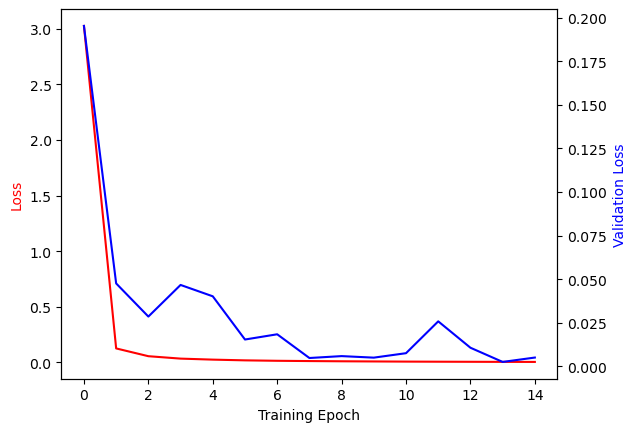

In [193]:
#
# Random forest does not generate a training history
#
if history is not None:
    plot_training_history(
        history.history["loss"], history.history["val_loss"], skip=0)

### Verify the operation of the model

We must verify the model is working across feature space. To do this we create a new set of scenarios and as the model to predict, we then compare to values generated by the original mathematical version. 

In [182]:
# Create new set of test scenarios
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
SPOT: Final[float] = 50.0
STRIKE: Final[float] = 50.0
MAT: Final[float] = 0.5
RATE: Final[float] = 0.025
VOL: Final[float] = 0.2

**Note**
There are three scenarios below, only run **one** of them at a time as they all return results to the same outputs. 
These outputs are used to plot the graphs that inspect the accuracy of the results. You can come back and run a different scenario and re-plot.

In [ ]:
# Scenario 1 : Rate vs Vol Scenario
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=SPOT, strike=STRIKE, mat=MAT, rate=rates, vol=vols, price_func=black_scholes_model
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=SPOT, strike=STRIKE, mat=MAT, rate=rates, vol=vols, price_func=model.predict
)

In [194]:
# Scenario 2 : Maturity vs Vol Scenario
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=SPOT, strike=STRIKE, mat=mats, rate=RATE, vol=vols, price_func=black_scholes_model
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=SPOT, strike=STRIKE, mat=mats, rate=RATE, vol=vols, price_func=model.predict
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

In [ ]:
# Scenario 3 : Spot vs Strike
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=spots, strike=strikes, mat=MAT, rate=RATE, vol=VOL, price_func=black_scholes_model,
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=spots, strike=strikes, mat=MAT, rate=RATE, vol=VOL, price_func=model.predict
)

In [ ]:
# Scenario 3 : Spot vs Vol
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=spots, strike=STRIKE, mat=MAT, rate=RATE, vol=vols, price_func=black_scholes_model,
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=spots, strike=STRIKE, mat=MAT, rate=RATE, vol=vols, price_func=model.predict
)

In [184]:
def plot_price_surface(
    xscen: np.ndarray,
    yscen: np.ndarray,
    actual: np.ndarray,
    predicted: np.ndarray,
    title: str,
    xscen_lab: str,
    yscen_lab: str,
    azimuth: float = -45,
    elevation: float = 30,
) -> None:
    """
    Plots a dual surface of actual vs predicted, with a contour plot of price difference as a percentage.

    Args:
        xscen (np.ndarray): The scenario values for the X-axis.
        yscen (np.ndarray): The scenario values for the Y-axis.
        actual (np.ndarray): 2D array of actual values for X and Y scenarios.
        predicted (np.ndarray): 2D array of neural net predicted values for X and Y scenarios.
        title (str): Graph title.
        xscen_lab (str): X-axis label.
        yscen_lab (str): Y-axis label.
        azimuth (float, optional): Azimuth angle for 3D plot. Defaults to -45.
        elevation (float, optional): Elevation angle for 3D plot. Defaults to 30.

    Returns:
        None
    """
    minz = min(np.min(actual), np.min(predicted))
    maxz = max(np.max(actual), np.max(predicted))

    X, Y = np.meshgrid(xscen, yscen)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_zlim3d(minz, maxz)
    c1 = ax.contourf(
        X,
        Y,
        ((actual - predicted) / np.maximum(1e-9, actual)) * 100.0,
        levels=range(-100, 100, 1),
        cmap=cm.RdGy,
        offset=np.min(minz),
    )
    _ = ax.plot_surface(
        X, Y, actual, cmap=cm.coolwarm, linewidth=0, edgecolor="none", alpha=0.7
    )
    _ = ax.plot_surface(
        X, Y, predicted, edgecolors="k", linewidth=0.1, color="gray", alpha=0.3
    )
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.05,
            ax.get_position().y0 + ((ax.get_position().height) * 0.15),
            0.02,
            (ax.get_position().height) * 0.7,
        ]
    )
    cb = fig.colorbar(c1, cax=cax)
    cb.ax.set_ylabel("% difference", rotation=270)
    ax.set_xlabel(xscen_lab)
    ax.set_ylabel(yscen_lab)
    ax.set_zlabel("Option Price")
    ax.set_title(title)
    ax.view_init(azim=azimuth, elev=elevation)
    plt.show()

## Actual vs Predicted

### Surface

We plot the actuals as a surface (blue-red) and then overlay the predicted as a translucent gray surface, so we can see where the two diverge. We also plot a contour of the % difference at every point.

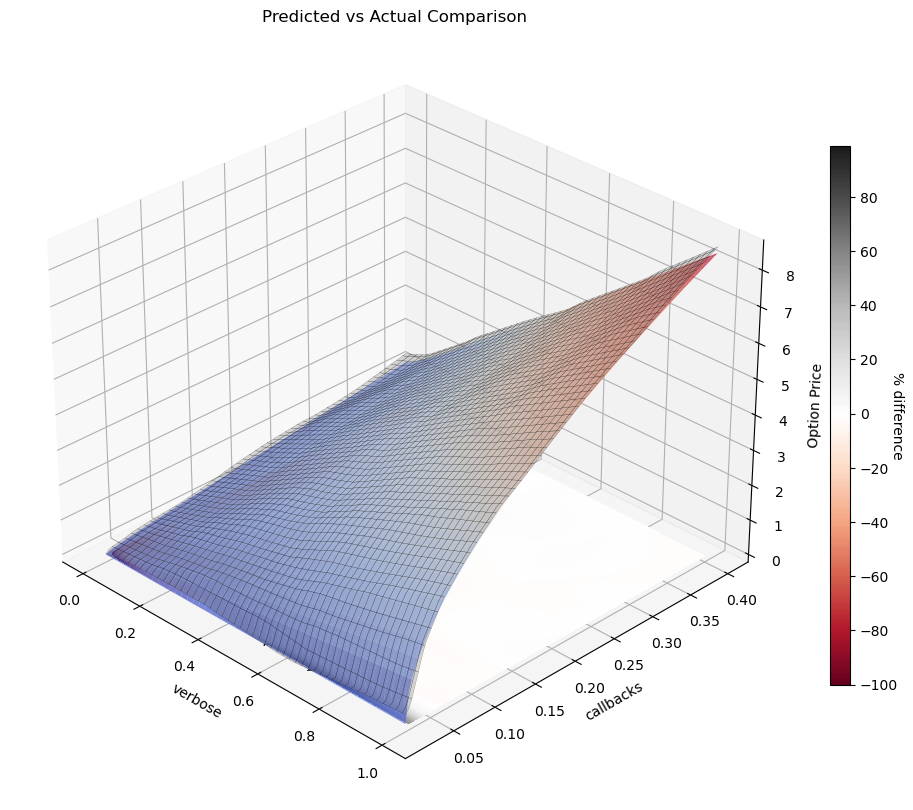

In [195]:
# Plot results from one of the last scenarios above that was run.
#
plot_price_surface(
    s1,
    s2,
    actual=actual,
    predicted=predicted,
    title="Predicted vs Actual Comparison",
    xscen_lab=s1n,
    yscen_lab=s2n,
)

### Scatter 
If we scatter plot actual vs predicted then we would expect to see a tight line, where the actual and predicted are the same for given inputs. So the more diffused the line the lower the fit between actual and predicted.

In [196]:
def plot_scatter(
    actual: List[float], predicted: List[float], title: str, x_lab: str, y_lab: str
) -> None:
    """
    Plot a scatter of actual vs predicted as a way to visualize differences.

    Args:
        actual (List[float]): 1D array of actual prices.
        predicted (List[float]): 1D array of predicted prices.
        title (str): Graph title.
        x_lab (str): X-axis label.
        y_lab (str): Y-axis label.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.scatter(actual.flatten(), predicted.flatten(), s=0.25)
    plt.show()
    return

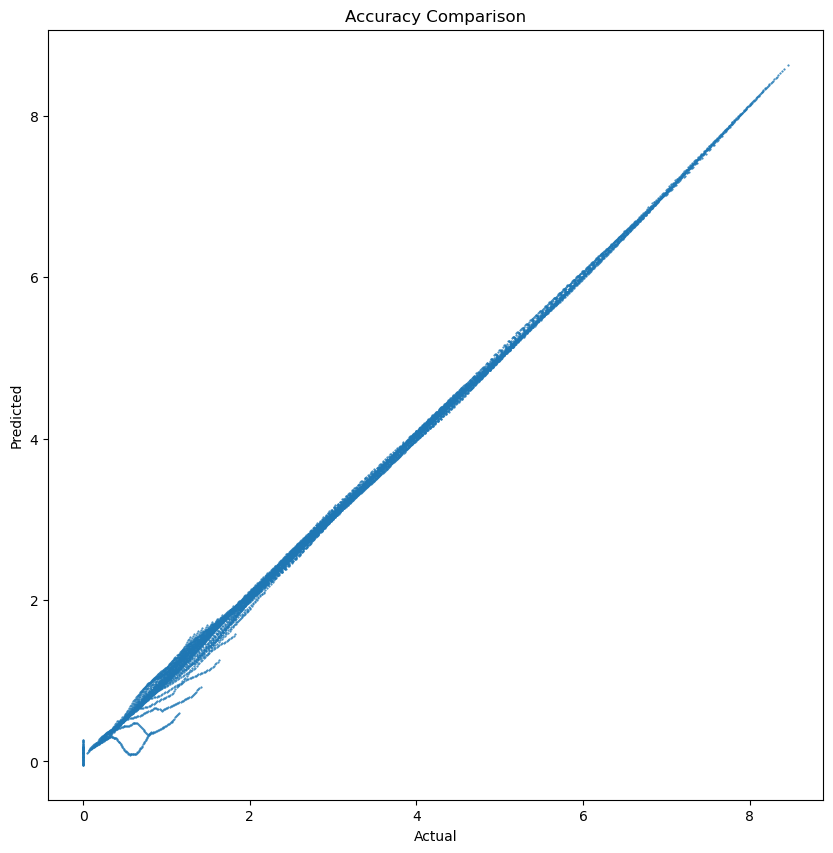

In [197]:
# Plot actual vs predicted (if you plot actual/actual or predicted/predicted - you will see s straight line)
#
plot_scatter(
    actual.flatten(),
    predicted.flatten(),
    x_lab="Actual",
    y_lab="Predicted",
    title="Accuracy Comparison",
)

### Option Greeks, specifically Delta

When trading options we need to know how the option behaves as the parameters change, Spot, Volatility etc .. these sensitivities to parameter changes are referred to as options greeks as they are named delta, gamma, vega, rho etc.

A critical one to know is delta, which is the rate of change of the option price as the spot price changes. For the closed form model we are using here, there is a closed form function for delta. However in the more complex options delta is calculated numerically. This is done by calculating an option price for a given spot level, and a the option price foe very small increase in spot. (very small as in 1/1'000'000). From this we can calculate the rate of change of option price with respect to change in spot.

We can use our trained network to generate the numerical delta and compare it to the closed form delta, this will be another indication of the viability of the trained network.

In [2]:
import numpy as np
def calculate_numerical_delta(model,
                              k: float = STRIKE,
                              do_scatter: bool = True,
                              spot_min: float = 1,
                              spot_max: float = 100) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Approximate the first-order derivative for the rate of change of payoff "delta" given a trained model.

    Args:
        model: The trained neural network with which to calculate numerical delta.
        k (float): The strike price. Defaults to STRIKE.
        do_scatter (bool): Whether to plot a scatter graph. Defaults to True.
        spot_min (float): The minimum spot price. Defaults to 1.
        spot_max (float): The maximum spot price. Defaults to 100.

    Returns:
        Tuple containing the spots, numerical deltas, and closed form deltas.
    """
    numerical_deltas = []
    closed_form_deltas = []
    small_change: Final[float] = 1e-6

    # Spot range must be within the trained range
    step_size = 0.005
    spots = [x * step_size for x in range(spot_min, int(spot_max / step_size))]
    x_p1 = np.zeros((len(spots), 5))
    x_p2 = np.zeros((len(spots), 5))

    for i, spot in enumerate(spots, 0):
        # Calculate the closed form delta
        _, delta = black_scholes_model(
            S=spot, K=k, T=MAT, r=RATE, v=VOL, with_delta=True
        )
        closed_form_deltas.append(delta)

        # Build up the scenarios to make batch calls to model predict outside of this loop.
        x_p1[i] = [spot, k, MAT, RATE, VOL]
        x_p2[i] = [spot + small_change, k, MAT, RATE, VOL]

    # Predict as batches
    p1 = model.predict(x_p1, verbose=0)
    p2 = model.predict(x_p2, verbose=0)

    # Numerical delta is the difference in price over spot increment
    numerical_deltas = ((p2 - p1) / small_change).tolist()
    # Deltas must be in the range of 0.0 to 1.0
    numerical_deltas = np.clip(numerical_deltas, 0.0, 1.0)

    

    # Plot the results vs the closed form to make it easy to visualize
    plot_dual_line(
        x=spots,
        y1=closed_form_deltas,
        y2=numerical_deltas,
        title="Step Barrier Actual vs Predicted",
        x_lab="Spot Price",
        y1_lab="Closed Form",
        y2_lab="NN Numeric",
    )

    if do_scatter:
        plot_scatter(
            np.array(closed_form_deltas),
            np.array(numerical_deltas),
            x_lab="Closed",
            y_lab="Numerical",
            title="Accuracy Comparison",
        )
    return np.array(spots), np.array(numerical_deltas), np.array(closed_form_deltas)

NameError: name 'STRIKE' is not defined

### Unstable Delta

We calculate the numerical dalta based on the current model and we see that it fits the general shape of delta but are not precise. This is due to accuracy limitations of the model as to calculate delta we are predicting prices with a very small interval between them.

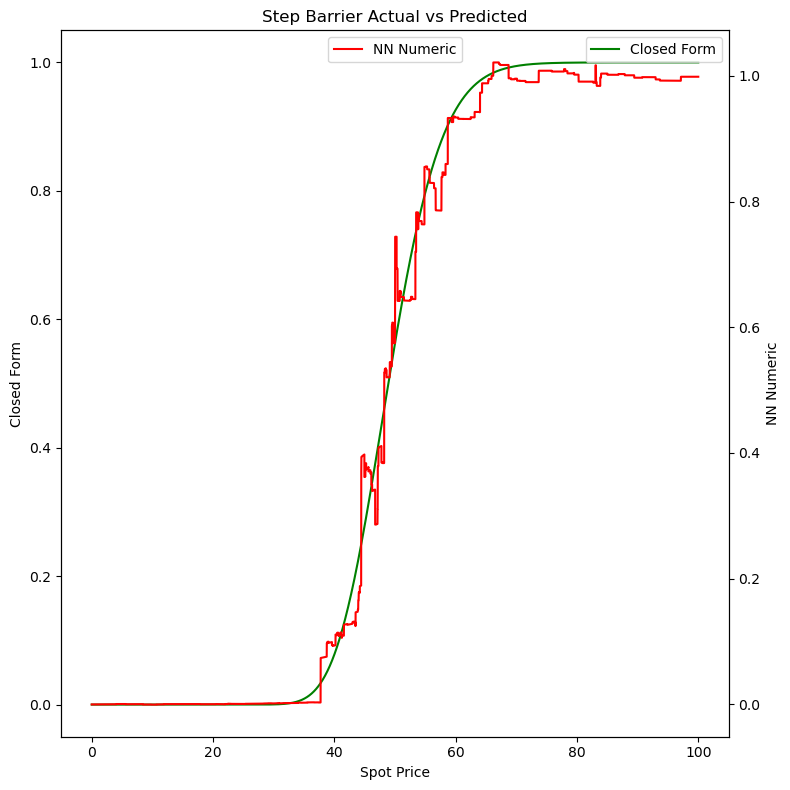

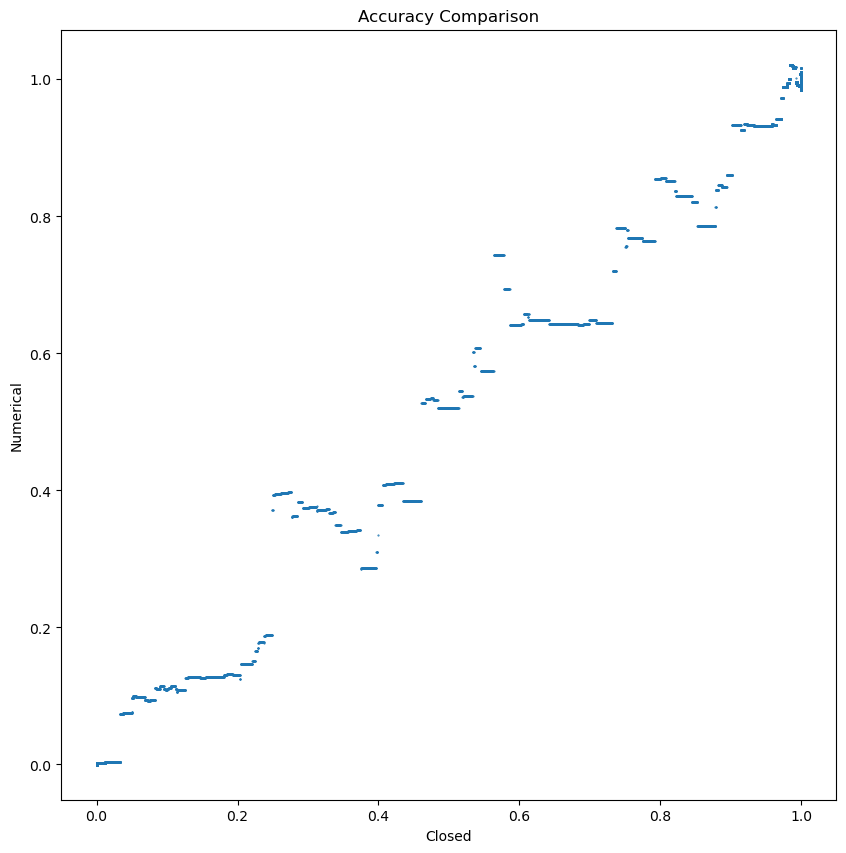

In [265]:
spots, numerical_deltas, closed_form_deltas = calculate_numerical_delta(model)

### Smoothing

As the points fit the shape of delta, we can use another simple neural network to generalise the shape of the underlying curve giving more precise results.

The fit however is not high precision and would have limited uses in practice.

In [266]:
numerical_deltas = np.array(numerical_deltas)
Spot_train, Spot_test, Delta_train, Delta_test = train_test_split(spots, numerical_deltas, test_size=0.2)

In [279]:
# Define a simple dense model architecture to learn and predict delta
delta_model = Sequential()
delta_model.add(Dense(64, input_shape=(1,)))  # First hidden layer
delta_model.add(PReLU())
delta_model.add(Dense(32 ))  # Second hidden layer
delta_model.add(PReLU())
delta_model.add(Dense(1,activation="linear"))  # Output layer

# Compile the model
delta_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lr=0.001
delta_model.fit(Spot_train, Delta_train, validation_data=(Spot_test, Delta_test), epochs=50, batch_size=8,callbacks=[lr_callback])

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0621 - val_loss: 0.0298
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000955.
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0499 - val_loss: 0.0303
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.00091225.
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0430 - val_loss: 0.0412
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0008716374999999999.
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0241 - val_loss: 0.0101
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.000833055625.
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to 0.0007964028437499999.
2000/2000 [===========

In [280]:
# We can now predict the delta for the entire spot range and compare it to the ideal case as predicted by the Black-Scholes model
delta_pred = delta_model.predict(spots)

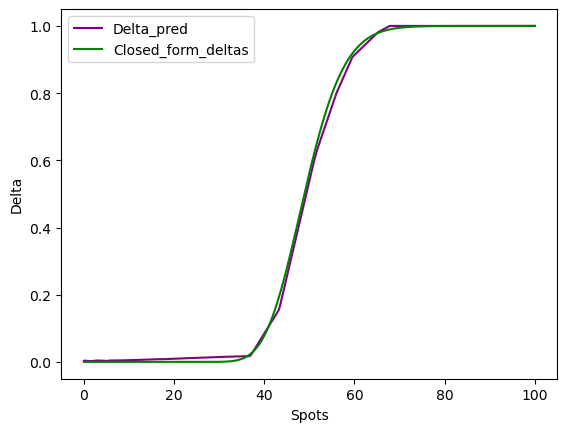

In [283]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(spots, delta_pred, color='purple', label='Delta_pred')
ax1.plot(spots, closed_form_deltas, color='green', label='Closed_form_deltas')
ax1.set_xlabel('Spots')
ax1.set_ylabel('Delta')
ax1.legend()

## Conclusion

We can see that it is possible to train a neural network for a financial contracts with a well behaved pay-off. We now add in an arbitrary feature that makes the pay-off harder to predict and type again.

The acid test, is that if we quoted options from the Neural Network, would we be over/under pricing, in which case we would be exposing an arbitrage opportunity to the market. In this case the market would be able to make mostly risk free profit from trading with us by monetising the miss-pricing. This would systematically costs us money to trade and ultimately we would be driven out of business.

### Best Case ...

We need to take a moment to consider the <sup>1</sup> joke below

> There’s this farmer, and he has these chickens, but they won’t lay any eggs. So, he calls a physicist to help. The physicist then does some calculations, and he says, um, I have a solution, but it only works with spherical chickens in a vacuum

Our *spherical chicken in a vacuum* is the Nobel winning [Black Scholes Model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model), while ground breaking, out of the box it represents a best case, where our option is a spherical chicken in a vacuum, with a well behaved pay off. In practice there are many embellishments required to accommodate dividends, early exercise, barriers, cross currency (quanto) etc. These embellishments make the pay off less well behaved in mathematical terms. This is relevant to us, as approximating functions with complex, sharp or instantaneous transitions with a large number of parameters is harder then approximating functions with a small number of parameters and smooth transitions. The real world use case where an options have a barrier conditions, where within a given range of pricing inputs the option behavior changes, sometimes instantaneously to zero value.

We can gain an intuition for this complexity by looking at Fourier transforms, which is another way of approximating functions. There is a way of modelling a sharp transition (step function) using Fourier transforms. However to effectively model this instantaneous transition we must allow ourselves to use functions of infinitely high frequency. Clearly this is not practical, so limit ourselves to finite frequencies that yield a workable level of accuracy. There is a similar trade off with neural networks, we cannot have infinitely complex networks, we must try to find the least complexity that can capture and generalise the payoff with a tradable level of accuracy and precision.

In the cells below, we show how fourier transforms work and compare five frequency terms versus one hundred frequency terms. Where more terms give us a very close approximation, but still an approximation.

The analogy with neural networks is that as the real world complexity rises, we require a significant amount of data and deep networks to capture the payoff.

So, let's have a look at the Fourier transform as a means to gain some intuition into this challenge.

<sup>1</sup> *Credit [Big Bang Theory](https://isntsciencewonderful.wordpress.com/2015/09/06/hofstadters-spherical-chickens/)*

In [16]:
def fourier_approx_of_step_function(num_fourier_terms: int = 5):
    """
    Calculate the first n terms of the fourier transform that approximates a cyclic step function.

    |---|   |---|
    |   |   |   |
    |   |---|   |---

    https://en.wikipedia.org/wiki/Fourier_series

    Keyword Arguments:
        num_fourier_terms -- number of fourier terms to include (default: {5})
    """
    num_increments = 100
    vals = np.asarray([(x / 100.0) * 4 * np.pi for x in range(num_increments)])
    res = np.asarray(
        [
            [(4 * np.sin(n * (v))) / (np.pi * n) for v in vals]
            for n in range(1, (num_fourier_terms * 2), 2)
        ]
    )
    return vals, res, res.sum(axis=0)

In [17]:
def plot_step_fnx(num_fourier_terms: int = 5):
    """
    Calculate and plot all of the sub terms of the Fourier transform for a step function.
    Plot the sub terms in grey & the final approximation (sum) in Red

    Keyword Arguments:
        num_fourier_terms -- number of fourier terms to include (default: {5})
    """
    vals, res, apx = fourier_approx_of_step_function(
        num_fourier_terms=num_fourier_terms
    )
    plt.clf()
    plt.title(f"{num_fourier_terms} terms")
    for i, r in enumerate(res):
        plt.plot(vals, r, color="gray", linewidth=max(
            0.0125, np.power(0.7, i)))
    plt.plot(vals, apx, color="red", linewidth=1)
    plt.show()
    return

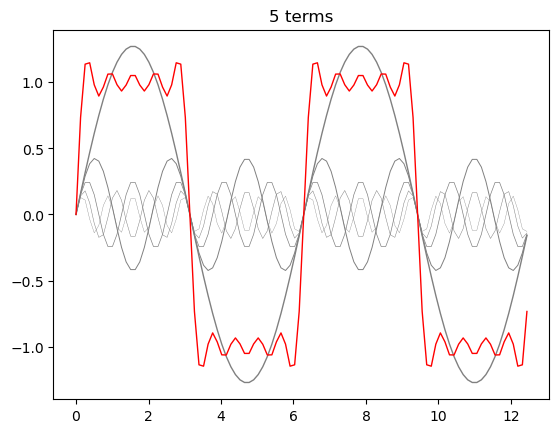

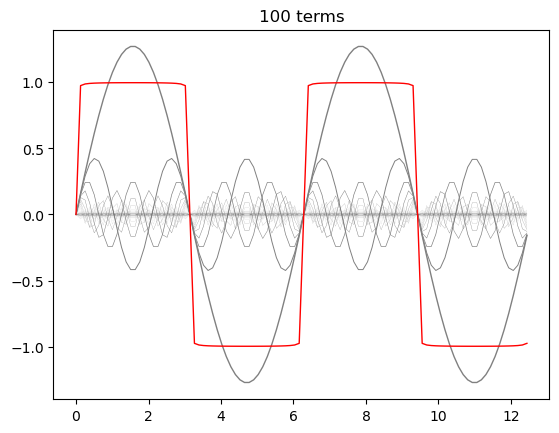

In [18]:
# We see the higher the number of terms the more closely we can approximate the step function.
# The implications are that the neural network has to work *harder* to approximate functions with
# sharp transitions. Where there sharp transitions are very common in the day to day of financial options
#
# In grey we can see all of the sub-terms, in red we can see the shape of the function we get if we add
# the sub terms together
#
plot_step_fnx(5)
plot_step_fnx(100)

So, now we have an intuition for the challenge in capturing complexity, we will add real world features to our option and see what we need to do the neural network model and supply of training data to try and capture this more complex form.

We start by adding barrier conditions, where the payoff changes for a defined range of inputs. We compare two types of barrier, one with smooth transitions and one with instantaneous ones, the latter, as above we expect to be harder to capture. 

### Smooth Barrier

We now model a barrier that has a rapid but smooth transition for the option price.

In [22]:
# These settings are arbitrary, and just chosen to place the barrier in the center
# of the range of spot prices, so it is easy to visualise when graphed.
#
# In practice, the barriers are normally selected by the buyer to fit a strategy they
# have in mind to protect against loss of speculate against expected market moves.
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)

price_max = spots[-1]
price_min = spots[0]
barrier_min = math.floor((
    price_max - price_min
) * 0.45)  # Barrier kicks in at 45% of the max option price
barrier_max = math.floor((
    price_max - price_min
) * 0.8)  # Barrier end at 80% of the max option price
print(f"Spot Min [{price_min:.03f}] Max [{price_max:.03f}], Barrier Min [{barrier_min:.03f}] Max [{barrier_max:.03f}]")

Spot Min [0.010] Max [100.000], Barrier Min [44.000] Max [79.000]


In [23]:
def smooth_barrier(
    p: float,
    S: float,
    v: float,
    T: float,
    barrier_spot_min: float,
    barrier_spot_max: float,
) -> float:
    """
    Takes the current option price and reduces it smoothly, but sharply if the spot price is in the min/max barrier range.

    Args:
        p: Unmodified option price
        S: Spot used to generate the given unmodified option price
        v: Volatility used to generate the given unmodified option price
        T: Maturity used to generate the given unmodified option price
        barrier_spot_min: The spot price above which the barrier operator is active
        barrier_spot_max: The spot price below which the barrier operator is active

    Returns:
        Option price adjusted for the defined barrier
    """
    scale_down = float(1)
    if S >= barrier_spot_min and S <= barrier_spot_max:
        scale_down = 1 - np.sin(
            ((S - barrier_spot_min) / (barrier_spot_max - barrier_spot_min)) * np.pi
        )

    return p * scale_down

In [24]:
# Pre-fill the additional params to barrier, so function conforms with our defined barrier prototype
#
smb = partial(
    smooth_barrier, barrier_spot_min=barrier_min, barrier_spot_max=barrier_max
)

In [25]:
# Run quick simulation to show shape of barrier
#
opt_prc = []
spot_prc = []
for s in range(1, 100):
    opt_prc.append(
        black_scholes_model(S=s, K=10, T=MAT, r=RATE, v=VOL, o=BSConstants.call, barrier=smb)[
            BSConstants.price]  # , barrier=smb)
    )
    spot_prc.append(s)

In [17]:
def plot_line(x: List[float], 
              y: List[float], 
              title: str = "", 
              x_lab: str = "", 
              y_lab: str = "") -> None:
    """
    Plots a simple line graph of a single variable.

    Args:
        x: 1D array of x values to plot.
        y: 1D array of y values to plot.
        title: Graph title.
        x_lab: X-axis label.
        y_lab: Y-axis label.
    """
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.plot(x, y)
    plt.show()
    return

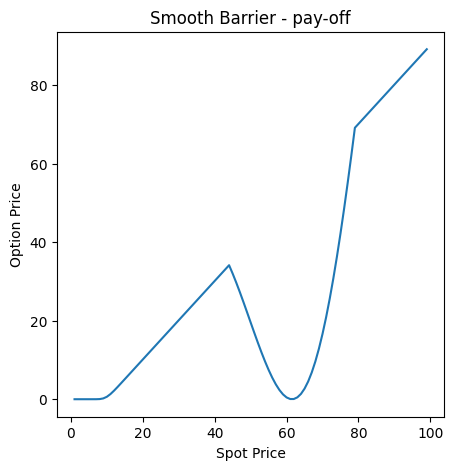

In [27]:
# Show the pay-off, with the addition of smooth barrier.
# We can see the payoff drop when the price in within the barrier range.
#
plot_line(
    x=spot_prc,
    y=opt_prc,
    title="Smooth Barrier - pay-off",
    x_lab="Spot Price",
    y_lab="Option Price",
)

In [31]:
#
# Generate a fresh set of training data for barrier type 1 = smooth barrier.
#

X_b1 = generate_model_scenarios(
    spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols
)
print(f"Generated {len(X_b1):,} training scenarios")
Y_b1 = [black_scholes_model(*params, barrier=smb)
        [BSConstants.price] for params in X_b1]
Xs_b1, Ys_b1 = shuffle(X_b1, Y_b1, random_state=42)

Generated 3,200,000 training scenarios


In [37]:
#
# Now fit the new training data with the same model architecture and see if it can (cope) generalise the more complex pay off.
#
#
model_b1, history_b1, X_train_b1, Y_train_b1, X_test_b1, Y_test_b1 = fit(
    Xs_b1, Ys_b1, ModelType.AVG_NET, num_epoch=200, batch_size=256
)

Create and fit Averaging Network
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 64)           384         ['input_2[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 16)           96          ['input_2[0][0]']                
                                                                                                  
 dense_17 (Dense)               (None, 64)           384         ['input_2[0][0]']                
                                                           

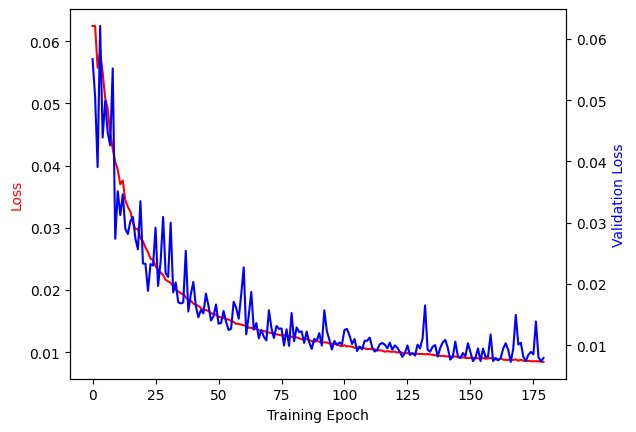

In [38]:
if history_b1 is not None:
    plot_training_history(
        history_b1.history["loss"], history_b1.history["val_loss"], skip=20
    )

In [42]:
# Calculate : Spot vs Vol for Smooth barrier
#
def bsmb(S: float, K: float, T: float, r: float, v: float, o: float = float(0)):
    return black_scholes_model(S, K, T, r, v, not (o), barrier=smb)


vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=spots, strike=20.0, mat=MAT, rate=RATE, vol=vols, price_func=bsmb
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=spots,
    strike=20.0,
    mat=1.0,
    rate=0.05,
    vol=vols,
    price_func=model_b1.predict,
    scaler=None,
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

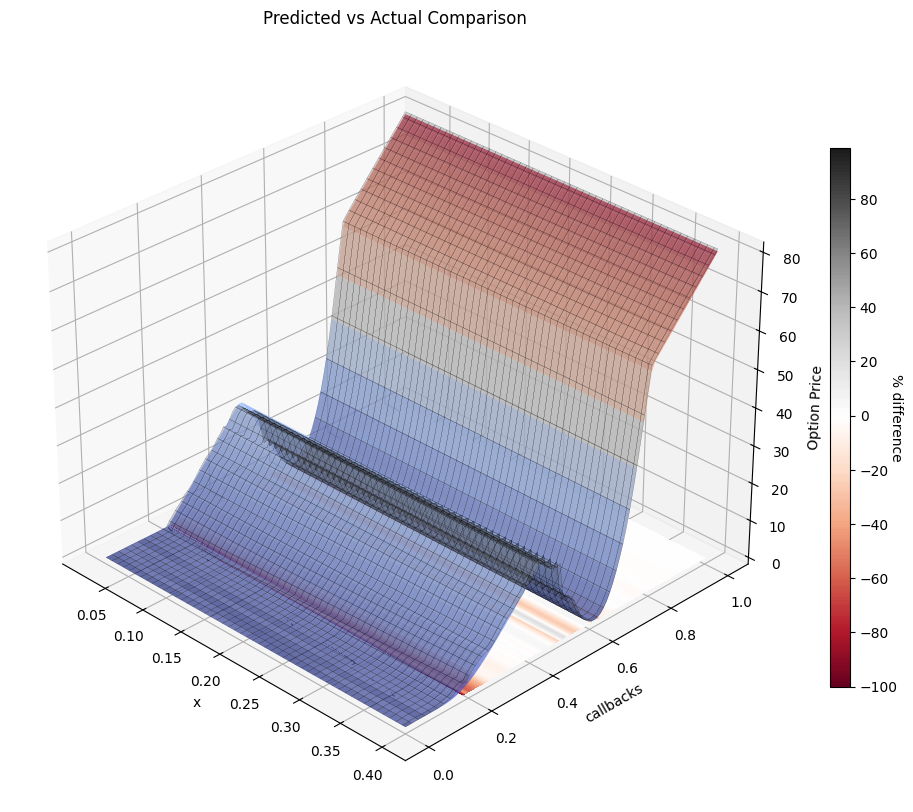

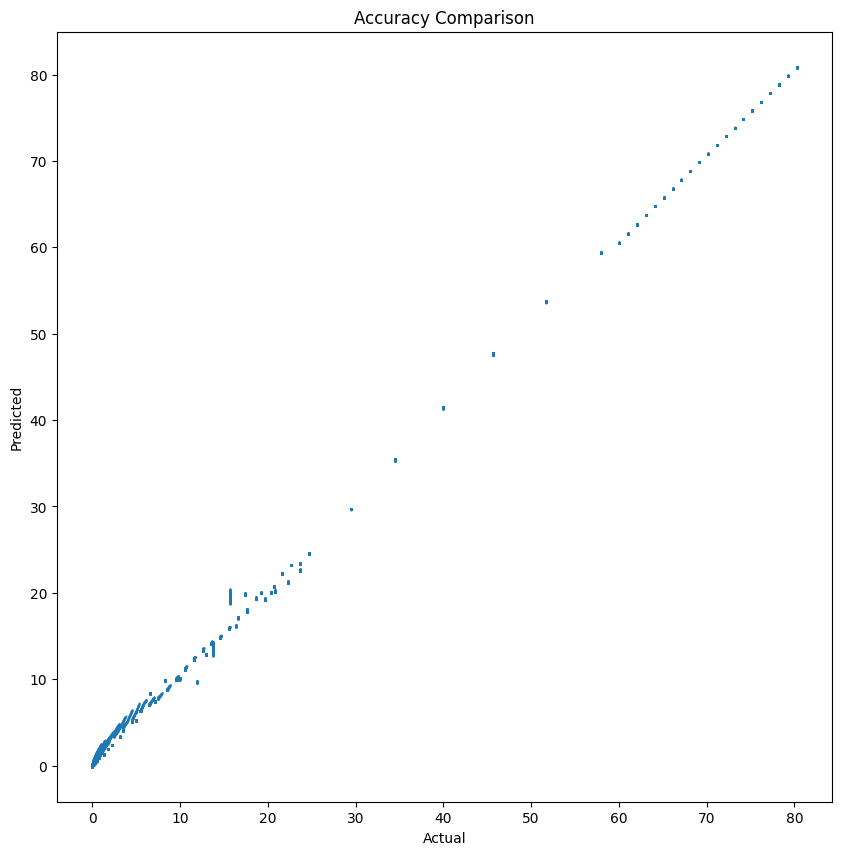

In [43]:
plot_price_surface(
    vols,  # Can swap these next two to see different scenarios
    mats,
    actual=actual,
    predicted=predicted,
    title="Predicted vs Actual Comparison",
    xscen_lab=s1n,
    yscen_lab=s2n,
)
plot_scatter(
    actual.flatten(),
    predicted.flatten(),
    x_lab="Actual",
    y_lab="Predicted",
    title="Accuracy Comparison",
)

In [19]:
def plot_dual_line(x: List[float], 
                   y1: List[float], 
                   y2: List[float], 
                   title: str = "",
                   x_lab: str = "", 
                   y1_lab: str = "", 
                   y2_lab: str = "") -> None:
    """
    Plots two lines on the same graph.

    Args:
        x: Common 1D array of x values to plot for y1 and y2.
        y1: First 1D array of y values to plot.
        y2: Second 1D array of y values to plot.
        title: Graph title.
        x_lab: X-axis label.
        y1_lab: y1-axis label.
        y2_lab: y2-axis label.
    """
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax2 = ax1.twinx()
    ax1.set_title(title)
    ax1.set_xlabel(x_lab)
    ax1.plot(x, y1, color="green")
    ax2.plot(x, y2, color="red")
    ax1.set_ylabel(y1_lab)
    ax2.set_ylabel(y2_lab)
    ax1.legend([y1_lab], loc=0)
    ax2.legend([y2_lab], loc=9)
    plt.tight_layout()
    plt.show()


In [ ]:
# Run a simulation to show shape of predicted price with barrier
#
opt_prc_pred = []
spot_prc = []
for s in range(1, 100):
    xs = np.asarray([s, 10, 1.0, 0.05, 0.3]).reshape((1, 5))
    opt_prc_pred.append(model_b1.predict(xs, verbose=0)[0])
    spot_prc.append(s)

plot_dual_line(
    x=spot_prc,
    y1=opt_prc,
    y2=opt_prc_pred,
    title="Smooth Barrier Actual vs Predicted",
    x_lab="Spot Price",
    y1_lab="Actual Option Price",
    y2_lab="Predicted Option Price",
)

### Step Barrier

We now try training with a barrier that has a sharp transition to zero, instantaneous transitions are difficult to model but are common in financial options.

In [20]:
def step_barrier(
    p: float,
    S: float,
    v: float,
    T: float,
    barrier_spot_min: float,
    barrier_spot_max: float,
) -> float:
    """
        Takes the current option price and reduces it to zero between spot min and max

        :param p: Unmodified option price
        :param s: spot used to generate the given unmodified option price
        :param v: vol used to generate the given unmodified option price
        :param T: Maturity used to generate the given unmodified option price
        :param barrier_spot_min: The spot price above which the barrier operator is active
        :param barrier_spot_max: The spot price below which the barrier operator is active
        
        :return: Modified option price.
    """
    scale_down = float(1)
    if S >= barrier_spot_min and S <= barrier_spot_max:
        scale_down = float(0)

    return p * scale_down

In [ ]:
# Pre-fill the additional params to barrier, so function conforms with expected prototype
#
sms = partial(step_barrier, barrier_spot_min=barrier_min,
              barrier_spot_max=barrier_max)
print(f"Spot Min [{price_min:.03f}] Max [{price_max:.03f}], Barrier Min [{barrier_min:.03f}] Max [{barrier_max:.03f}]")

Spot Min [0.010] Max [100.000], Barrier Min [44.000] Max [79.000]


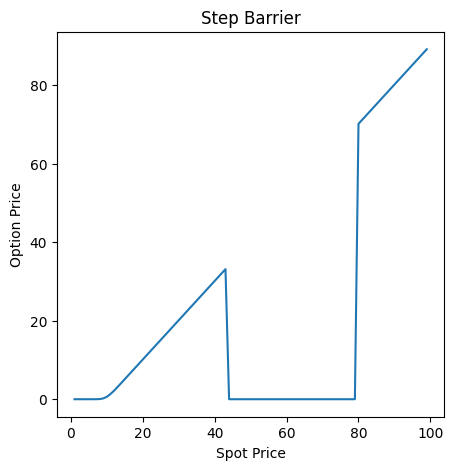

In [ ]:
# Run quick simulation to show shape of barrier
#
opt_prc = []
spot_prc = []
for s in range(1, 100):
    opt_prc.append(
        black_scholes_model(S=s, K=10, T=MAT, r=RATE, v=VOL,
                            o=BSConstants.call, barrier=sms)
    )
    spot_prc.append(s)

plot_line(
    x=spot_prc,
    y=opt_prc,
    title="Step Barrier",
    x_lab="Spot Price",
    y_lab="Option Price",
)

In [ ]:
#
# Generate a fresh set of training data for barrier type 2 = step barrier.
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=25)
X_b2 = generate_model_scenarios(
    spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols
)
print(f"Generated {len(X_b2)} training scenarios")
Y_b2 = [black_scholes_model(*params, barrier=sms)
        [BSConstants.price] for params in X_b2]
Xs_b2, Ys_b2 = shuffle(X_b2, Y_b2, random_state=42)

Generated 9765625 training scenarios


Create and fit Averaging Network
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_26 (Dense)               (None, 64)           384         ['input_3[0][0]']                
                                                                                                  
 dense_24 (Dense)               (None, 16)           96          ['input_3[0][0]']                
                                                                                                  
 dense_29 (Dense)               (None, 64)           384         ['input_3[0][0]']                
                                                           

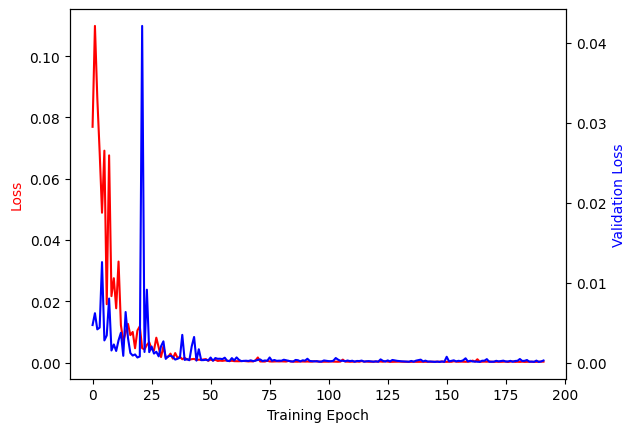

In [ ]:
#
# Now fit the new training data with the same model architecture and see if it can (cope) generalise the more complex pay off.
#

# model_b2, history_b2, X_train_b2, Y_train_b2, X_test_b2, Y_test_b2 = fit(
#    Xs_b2, Ys_b2, ModelType.NEURAL_NET)

model_b2, history_b2, X_train_b2, Y_train_b2, X_test_b2, Y_test_b2 = fit(
    Xs_b2, Ys_b2, ModelType.AVG_NET, num_epoch=200, batch_size=256
)

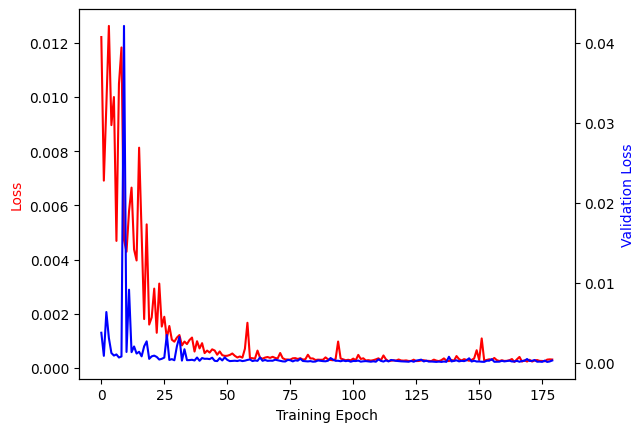

In [ ]:
if history_b2 is not None:
    plot_training_history(
        history_b2.history["loss"], history_b2.history["val_loss"], skip=20
    )

In [ ]:
# Calculate : Spot vs Vol for Step Barrier
#
def bsms(S: float, K: float, T: float, r: float, v: float, o: float = float(0)):
    return black_scholes_model(S, K, T, r, v, not (o), barrier=sms)


vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)

s1, s1n, s2, s2n, actual = two_d_scenario(
    spot=spots, strike=10.0, mat=MAT, rate=RATE, vol=vols, price_func=bsms
)
s1, s1n, s2, s2n, predicted = two_d_scenario(
    spot=spots,
    strike=10.0,
    mat=MAT,
    rate=RATE,
    vol=vols,
    price_func=model_b2.predict,
    scaler=None,
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

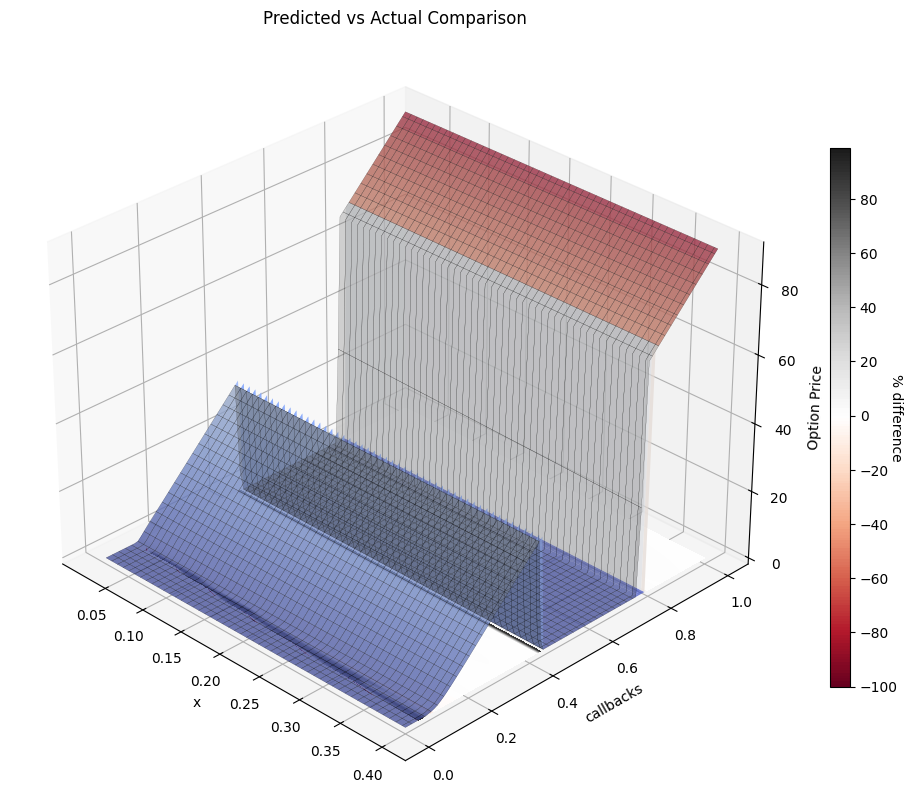

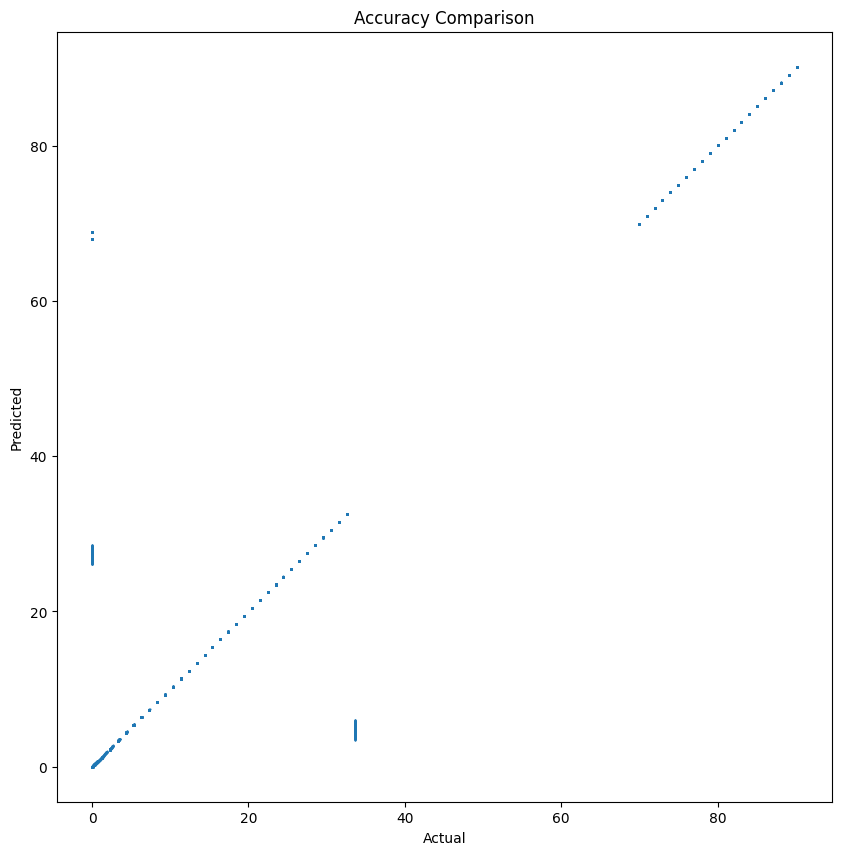

In [ ]:
plot_price_surface(
    vols,  # Can swap these next two to see different scenarios
    mats,
    actual=actual,
    predicted=predicted,
    title="Predicted vs Actual Comparison",
    xscen_lab=s1n,
    yscen_lab=s2n,
)

plot_scatter(
    actual.flatten(),
    predicted.flatten(),
    x_lab="Actual",
    y_lab="Predicted",
    title="Accuracy Comparison",
)

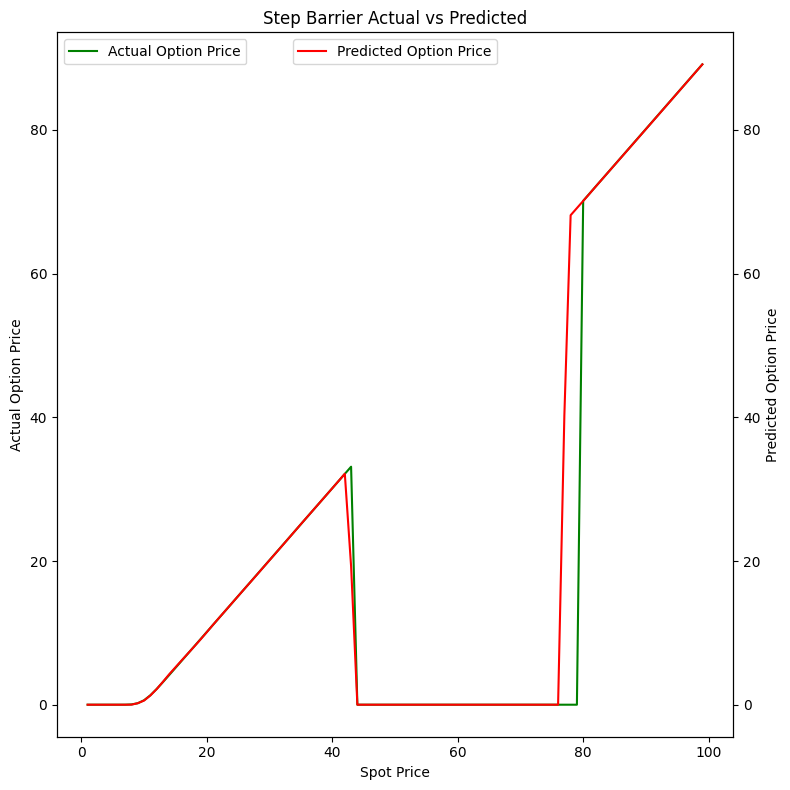

In [ ]:
# Run a simulation to show shape of predicted price with barrier
#
opt_prc_pred = []
spot_prc = []
for s in range(1, 100):
    xs = np.asarray([s, 10, MAT, RATE, VOL]).reshape((1, 5))
    opt_prc_pred.append(model_b2.predict(xs, verbose=0)[0])
    spot_prc.append(s)

plot_dual_line(
    x=spot_prc,
    y1=opt_prc,
    y2=opt_prc_pred,
    title="Step Barrier Actual vs Predicted",
    x_lab="Spot Price",
    y1_lab="Actual Option Price",
    y2_lab="Predicted Option Price",
)

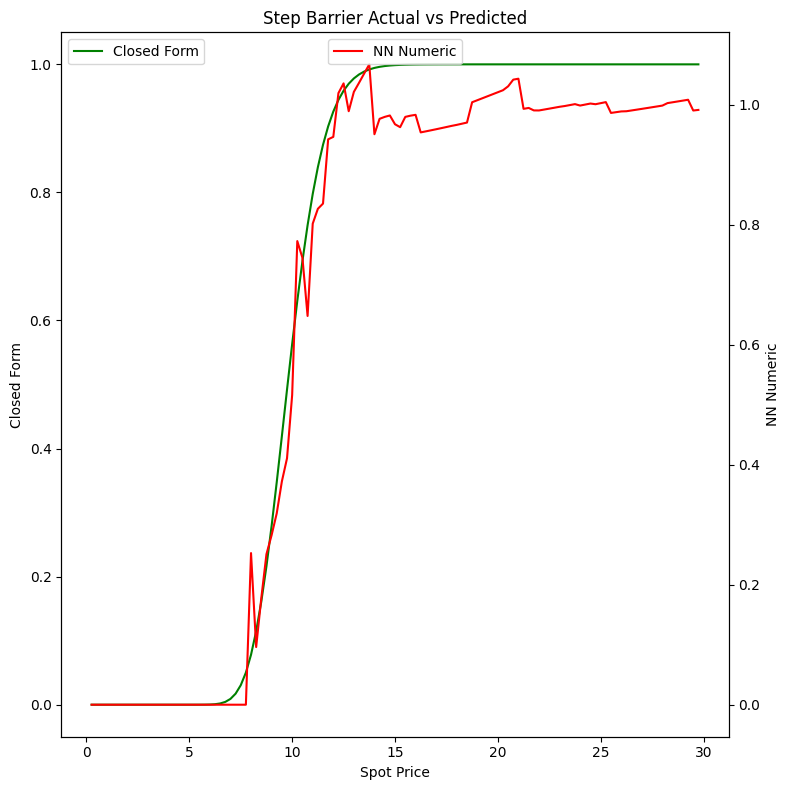

In [ ]:
calculate_numerical_delta(
    model_b2, k=10, do_scatter=False, spot_min=1, spot_max=30)

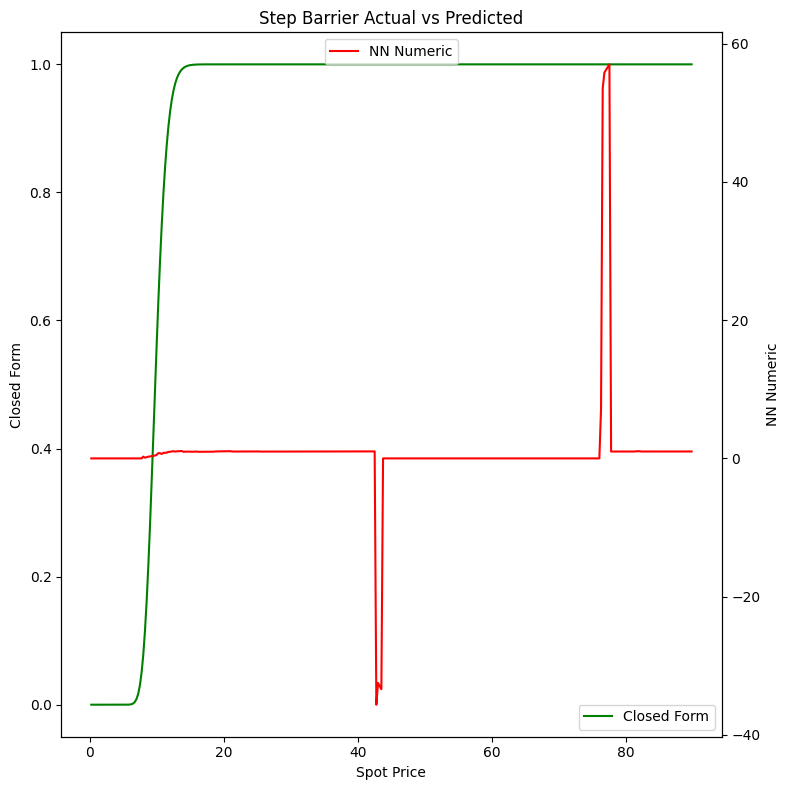

In [ ]:
calculate_numerical_delta(
    model_b2, k=10, do_scatter=False, spot_min=1, spot_max=90)

## Path Dependant

Now we have completed a basic proof of concept with simple closed form, we move on to look at path dependant options with a much higher cost of compute and an even more complex payoff function.

To get going we have taken a path dependant option from an open source git repo, that is implemented as a tensor flow model that can run on a GPU. We need this as calculating millions of path dependant option values for training takes days or elapse time, even with a GPU.

This type of option allows for an early exercise, where the buyer can exit the contract before the defined maturity date. As such this is another type of feature for the neural network to learn.

So, we follow the same pattern, by creating a set of all possible features, which comes to more than 12 million points even on a fairly corse grid. The value of the option for each scenario is then calculated. This gives us a training data set, but this time it is expensive to calculate and as the payoff is more complex we need more data. This highlights the trend that will be a challenge for this approach, the more complex the option, the more data we need which is now more expensive to compute. Which is why we try to use past quotes (calculations) as we have these for free. However they may not evenly cover the feature space we need to train for

In [21]:
#
# https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/black_scholes/crr_binomial_tree_test.py
#


def _get_payoff_fn(strikes, is_call_options):
    """Constructs the payoff functions."""
    option_signs = tf.cast(is_call_options, dtype=strikes.dtype) * 2 - 1

    def payoff(spots):
        """Computes payff for the specified options given the spot grid.

        Args:
          spots: Tensor of shape [batch_size, grid_size, 1]. The spot values at some
            time.

        Returns:
          Payoffs for exercise at the specified strikes.
        """
        return tf.nn.relu((spots - strikes) * option_signs)

    return payoff


def _get_value_modifier(is_american, payoff_fn):
    """Constructs the value modifier for american style exercise."""

    def modifier(values, spots):
        immediate_exercise_value = payoff_fn(spots)
        return tf.where(
            is_american, tf.math.maximum(
                immediate_exercise_value, values), values
        )

    return modifier


def option_price_binomial(
    *,
    volatilities,
    strikes,
    expiries,
    spots,
    discount_rates=None,
    dividend_rates=None,
    is_call_options=None,
    is_american=None,
    num_steps=100,
    dtype=None,
    name=None,
):
    """Computes the BS price for a batch of European or American options.

    Uses the Cox-Ross-Rubinstein version of the binomial tree method to compute
    the price of American or European options. Supports batching of the options
    and allows mixing of European and American style exercises in a batch.
    For more information about the binomial tree method and the
    Cox-Ross-Rubinstein method in particular see the references below.

    #### Example

    ```python
    # Prices 5 options with a mix of Call/Put, American/European features
    # in a single batch.
    dtype = np.float64
    spots = np.array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=dtype)
    strikes = np.array([3.0, 3.0, 3.0, 3.0, 3.0], dtype=dtype)
    volatilities = np.array([0.1, 0.22, 0.32, 0.01, 0.4], dtype=dtype)
    is_call_options = np.array([True, True, False, False, False])
    is_american = np.array([False, True, True, False, True])
    discount_rates = np.array(0.035, dtype=dtype)
    dividend_rates = np.array([0.02, 0.0, 0.07, 0.01, 0.0], dtype=dtype)
    expiries = np.array(1.0, dtype=dtype)

    prices = option_price_binomial(
        volatilities=volatilities,
        strikes=strikes,
        expiries=expiries,
        spots=spots,
        discount_rates=discount_rates,
        dividend_rates=dividend_rates,
        is_call_options=is_call_options,
        is_american=is_american,
        dtype=dtype)
    # Prints [0., 0.0098847, 0.41299509, 0., 0.06046989]
    ```

    #### References

    [1] Hull, John C., Options, Futures and Other Derivatives. Pearson, 2018.
    [2] Wikipedia contributors. Binomial Options Pricing Model. Available at:
      https://en.wikipedia.org/wiki/Binomial_options_pricing_model

    Args:
      volatilities: Real `Tensor` of any shape and dtype. The volatilities to
        expiry of the options to price.
      strikes: A real `Tensor` of the same dtype and compatible shape as
        `volatilities`. The strikes of the options to be priced.
      expiries: A real `Tensor` of same dtype and compatible shape as
        `volatilities`. The expiry of each option. The units should be such that
        `expiry * volatility**2` is dimensionless.
      spots: A real `Tensor` of any shape that broadcasts to the shape of the
        `volatilities`. The current spot price of the underlying.
      discount_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. The risk free discount rate. If None the rate is assumed
        to be 0.
        Default value: None, equivalent to discount rates = 0..
      dividend_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. If None the rate is assumed to be 0.
        Default value: None, equivalent to discount rates = 1.
      is_call_options: A boolean `Tensor` of a shape compatible with
        `volatilities`. Indicates whether the option is a call (if True) or a put
        (if False). If not supplied, call options are assumed.
        Default value: None, equivalent to is_call_options = True.
      is_american: A boolean `Tensor` of a shape compatible with `volatilities`.
        Indicates whether the option exercise style is American (if True) or
        European (if False). If not supplied, European style exercise is assumed.
        Default value: None, equivalent to is_american = False.
      num_steps: A positive scalar int32 `Tensor`. The size of the time
        discretization to use.
        Default value: 100.
      dtype: Optional `tf.DType`. If supplied, the dtype to be used for conversion
        of any supplied non-`Tensor` arguments to `Tensor`.
        Default value: None which maps to the default dtype inferred by TensorFlow
          (float32).
      name: str. The name for the ops created by this function.
        Default value: None which is mapped to the default name `option_price`.

    Returns:
      A `Tensor` of the same shape as the inferred batch shape of the input data.
      The Black Scholes price of the options computed on a binomial tree.
    """
    with tf.name_scope(name or "crr_option_price"):
        strikes = tf.convert_to_tensor(strikes, dtype=dtype, name="strikes")
        dtype = strikes.dtype
        volatilities = tf.convert_to_tensor(
            volatilities, dtype=dtype, name="volatilities"
        )
        expiries = tf.convert_to_tensor(expiries, dtype=dtype, name="expiries")
        spots = tf.convert_to_tensor(spots, dtype=dtype, name="spots")

        if discount_rates is None:
            discount_rates = tf.zeros_like(volatilities)
        else:
            discount_rates = tf.convert_to_tensor(
                discount_rates, dtype=dtype, name="discount_rates"
            )
        if dividend_rates is None:
            dividend_rates = tf.zeros_like(volatilities)
        else:
            dividend_rates = tf.convert_to_tensor(
                dividend_rates, dtype=dtype, name="dividend_rates"
            )
        if is_call_options is None:
            is_call_options = tf.ones_like(
                volatilities, dtype=tf.bool, name="is_call_options"
            )
        else:
            is_call_options = tf.convert_to_tensor(
                is_call_options, dtype=tf.bool, name="is_call_options"
            )
        if is_american is None:
            is_american = tf.zeros_like(
                volatilities, dtype=tf.bool, name="is_american")
        else:
            is_american = tf.convert_to_tensor(
                is_american, dtype=tf.bool, name="is_american"
            )

        num_steps = tf.cast(num_steps, dtype=dtype)
        dt = expiries / num_steps

        # CRR choices for the up and down move multipliers
        ln_up = volatilities * tf.math.sqrt(dt)
        ln_dn = -ln_up

        # Prepares the spot grid.
        grid_idx = tf.range(num_steps + 1)
        # Stores the grid as shape [input_batch, N + 1] where N = num_steps.
        log_spot_grid_1 = tf.expand_dims(
            tf.math.log(spots) + ln_up * num_steps, axis=-1
        )
        log_spot_grid_2 = tf.expand_dims(ln_dn - ln_up, axis=-1) * grid_idx
        log_spot_grid = log_spot_grid_1 + log_spot_grid_2

        # Adding the new dimension is to ensure that batch shape is at the front.
        payoff_fn = _get_payoff_fn(
            tf.expand_dims(
                strikes, axis=-1), tf.expand_dims(is_call_options, axis=-1)
        )
        value_mod_fn = _get_value_modifier(
            tf.expand_dims(is_american, axis=-1), payoff_fn
        )

        # Shape [batch shape, num time steps + 1]
        values_grid = payoff_fn(tf.math.exp(log_spot_grid))

        p_up = tf.math.exp((discount_rates - dividend_rates) * dt + ln_up) - 1
        p_up /= tf.math.exp(2 * ln_up) - 1
        p_up = tf.expand_dims(p_up, axis=-1)
        p_dn = 1 - p_up
        discount_factors = tf.expand_dims(
            tf.math.exp(-discount_rates * dt), axis=-1)
        ln_up = tf.expand_dims(ln_up, axis=-1)

        def one_step_back(current_values, current_log_spot_grid):
            next_values = (
                current_values[..., 1:] * p_dn +
                current_values[..., :-1] * p_up
            )
            next_log_spot_grid = current_log_spot_grid[..., :-1] - ln_up
            next_values = value_mod_fn(
                next_values, tf.math.exp(next_log_spot_grid))
            return discount_factors * next_values, next_log_spot_grid

        def should_continue(current_values, current_log_spot_grid):
            del current_values, current_log_spot_grid
            return True

        batch_shape = values_grid.shape[:-1]
        pv, _ = tf.while_loop(
            should_continue,
            one_step_back,
            (values_grid, log_spot_grid),
            maximum_iterations=tf.cast(num_steps, dtype=tf.int32),
            shape_invariants=(
                tf.TensorShape(batch_shape + [None]),
                tf.TensorShape(batch_shape + [None]),
            ),
        )
        return tf.where(
            expiries > 0,
            tf.squeeze(pv, axis=-1),
            tf.where(
                is_call_options,
                tf.math.maximum(spots - strikes, 0),
                tf.math.maximum(strikes - spots, 0),
            ),
        )

In [22]:
def option_price_binomial_w(
    spots,
    strikes,
    expiries,
    discount_rates,
    volatilities,
    is_call_options,
    is_american
):
    """
    Wrapper to change argument order.

    """
    return option_price_binomial(volatilities=volatilities,
                                 strikes=strikes,
                                 expiries=expiries,
                                 spots=spots,
                                 discount_rates=discount_rates,
                                 dividend_rates=None,
                                 is_call_options=is_call_options,
                                 is_american=is_american,
                                 num_steps=100,
                                 dtype=tf.float64,
                                 name=None)

In [ ]:
#
# Simple test to show the model can be tuned to price the same as the simple model
#

path_res = []
cfrm_res = []
vols = []

v = 0.05
S = 3.0
K = 3.0
T = 1.0
r = 0.035

for i in range(100):
    vols.append(v)
    path_res.append(
        np.float64(
            option_price_binomial(
                volatilities=v,
                strikes=K,
                expiries=T,
                spots=S,
                discount_rates=r,
                dividend_rates=0.0,
                is_call_options=bool(BSConstants.call),
                is_american=bool(BSConstants.european),
                num_steps=100,
                dtype=np.float64,
            )
        )
    )
    cfrm_res.append(black_scholes_model(
        S=S, K=K, T=T, r=r, v=v, o=BSConstants.call))
    v += 0.05

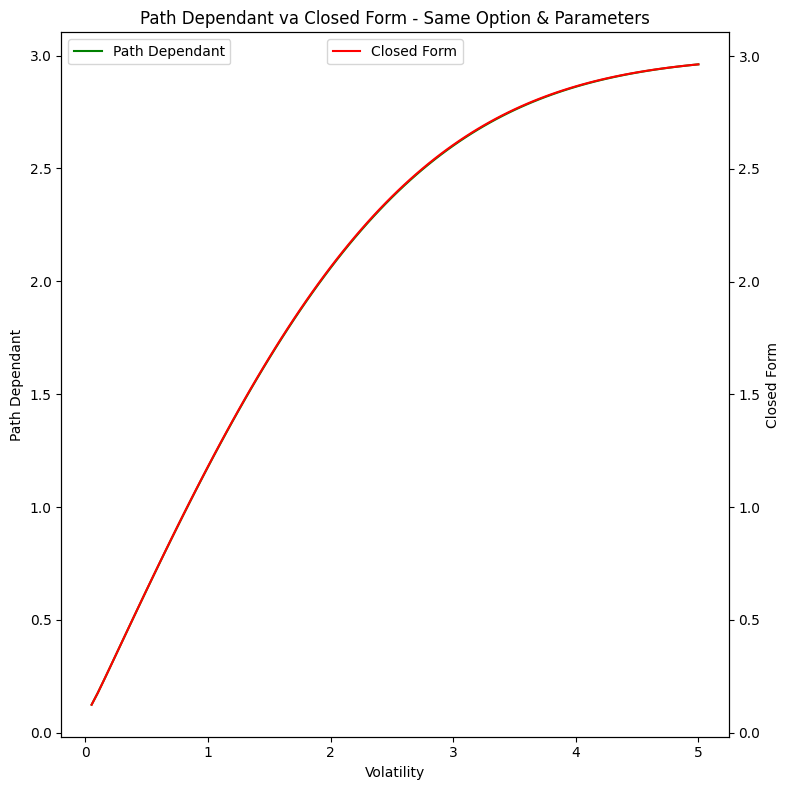

In [ ]:
plot_dual_line(
    x=vols,
    y1=path_res,
    y2=cfrm_res,
    title="Path Dependant va Closed Form - Same Option & Parameters",
    x_lab="Volatility",
    y1_lab="Path Dependant",
    y2_lab="Closed Form",
)

In [ ]:
# Differences are relativly small, as the close form is just a different way of calculating the same thing
# however, it can deal with more complex cases than the closed form.
#
np.std(np.asarray(path_res) - np.asarray([x[0] for x in cfrm_res]))

0.0013570075925214678

## Extend feature set

We need to extend the feature set to cover the option style, Call or Put and early exercise or not, American or European

These string features needed encoding as numerical values so they can be passed to the model.

In [ ]:
# Generate features without type and style.
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(
    spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)

In [23]:
def generate_random_scenarios(num_scenarios: int = 1000) -> np.array:
    """
    Generate random pricing scenarios to train the model with

    :param num_scenarios : Number of scenarios to generate
    :return: numpy array of uniform randomly generated scenarios of [vol, maturity, spot, strike, rate, call/put, european/american]
    
    """
    vols = np.random.uniform(0.01, 0.5, num_scenarios)
    mats = np.random.uniform(0.01, 1.5, num_scenarios)
    spots = np.random.uniform(0.01, 100.0, num_scenarios)
    strikes = np.random.uniform(1, 80, num_scenarios)
    rates = np.random.uniform(0.01, 0.4, num_scenarios)
    cp = [[BSConstants.call, BSConstants.put][i] for i in np.random.randint(2, size=num_scenarios)]
    ae = [[BSConstants.european, BSConstants.american][i] for i in np.random.randint(2, size=num_scenarios)]
    return np.stack([spots, strikes, mats, rates, vols, cp, ae],axis=-1)


In [27]:
X = generate_random_scenarios(50000000)
print(f"Num training {len(X):,}")

Num training 50,000,000


In [28]:
# Shuffle the training data
#
print(
    f"There are now {len(X):,} random generated training data points"
)
Xs = shuffle(X, random_state=42)
dfxs = pd.DataFrame(
    Xs,
    columns=[
        "spot",
        "strike",
        "maturity",
        "rate",
        "volatility",
        "call_put",
        "amer_eur",
    ],
)
dfxs.to_csv("XPathDependant.csv", encoding="ascii", index=False)

There are now 50,000,000 random generated training data points


In [348]:
!dir XPathDependant.csv

 Volume in drive D is DATA
 Volume Serial Number is 826F-76E6

 Directory of d:\devroot\optprice\jupyter

23/03/2024  16:46     5,192,227,275 XPathDependant.csv
               1 File(s)  5,192,227,275 bytes
               0 Dir(s)  1,728,012,734,464 bytes free


In [29]:
def run_scenarios(X_train: np.ndarray) -> np.ndarray:
    """ Use the binomial option pricing model to price every scenario passed in X_Train
    Args:
        X_train (np.ndarray): numpy array where each row is Spot, Strike, Time to maturity, risk free rate, volatility, is_call, is_american

    Returns:
        np.ndarray: Spot, Strike, Time to maturity, risk free rate, volatility, is_call, is_american, Price
    """
    res = []
    num_rows, num_cols = np.shape(X_train)
    # Split by column as model can price in bulk on GPU as it is written in Tensor Flow.
    S, K, T, r, v, cp, ae = np.hsplit(X_train, num_cols)
    S = S.reshape(num_rows)
    K = K.reshape(num_rows)
    T = T.reshape(num_rows)
    r = r.reshape(num_rows)
    v = v.reshape(num_rows)
    cp = cp.reshape(num_rows)
    ae = ae.reshape(num_rows)
    d = np.zeros((num_rows))  # Div yield is always zero for our purpose.

    prices = option_price_binomial(
        volatilities=v,
        strikes=K,
        expiries=T,
        spots=S,
        discount_rates=r,
        dividend_rates=d,
        is_call_options=cp,
        is_american=ae,
        num_steps=200,
        dtype=np.float64)

    return np.append(X_train, prices.numpy().reshape((num_rows, 1)), axis=1)

In [30]:
# Create a new CSV file for results and write a header row.

# This data is super expensive to re-create so the file create from scratch is commented out

f = open("binomial_training.csv", "w")
f.write(f"Spot,Strike,Maturity,rate,volatility,isPut,isEuropean,price\n")
f.close()

In [31]:
# Iterate over the pre-shuffled pandas X_train data in blocks, writing results out as we
# go. There are millions of training examples, so we want to make sure results are saved
# down. So, fo each block we flush, close and re-open the file in append mode.
base = 0
sz = 100000
all = len(dfxs)

while base < all:
    # Open in append.
    f = open("binomial_training.csv", "a")

    pdx = dfxs.iloc[base: base + sz]
    X_train = (pdx).to_numpy()
    results = run_scenarios(X_train)
    for r in results:
        S, K, T, r, v, cp, ae, p = r
        f.write(f"{S},{K},{T},{r},{v},{cp},{ae},{p}\n")
    f.flush()
    f.close()
    base = min(base + sz, all)
    print(f"{base:,} of {all:,}")

100,000 of 50,000,000
200,000 of 50,000,000
300,000 of 50,000,000
400,000 of 50,000,000
500,000 of 50,000,000
600,000 of 50,000,000
700,000 of 50,000,000
800,000 of 50,000,000
900,000 of 50,000,000
1,000,000 of 50,000,000
1,100,000 of 50,000,000
1,200,000 of 50,000,000
1,300,000 of 50,000,000
1,400,000 of 50,000,000
1,500,000 of 50,000,000
1,600,000 of 50,000,000
1,700,000 of 50,000,000
1,800,000 of 50,000,000
1,900,000 of 50,000,000
2,000,000 of 50,000,000
2,100,000 of 50,000,000
2,200,000 of 50,000,000
2,300,000 of 50,000,000
2,400,000 of 50,000,000
2,500,000 of 50,000,000
2,600,000 of 50,000,000
2,700,000 of 50,000,000
2,800,000 of 50,000,000
2,900,000 of 50,000,000
3,000,000 of 50,000,000
3,100,000 of 50,000,000
3,200,000 of 50,000,000
3,300,000 of 50,000,000
3,400,000 of 50,000,000
3,500,000 of 50,000,000
3,600,000 of 50,000,000
3,700,000 of 50,000,000
3,800,000 of 50,000,000
3,900,000 of 50,000,000
4,000,000 of 50,000,000
4,100,000 of 50,000,000
4,200,000 of 50,000,000
4,300,000 

In [ ]:
# Needs some clean post split up as it splits lines
#
def split_file(filename: str, size_in_MB: int = 10) -> None:
    """
    split the given file into smaller files of the given size

    :param filename     : The name of the file to split
    :param size_in_MB   : Size in MB of the chunked files

    :credit to: https://stackoverflow.com/users/239247/anatoly-techtonik
    """
    MAX = size_in_MB * 1024 * 1024
    BUF = 50 * 1024 * 1024 * 1024  # 50GB   - memory buffer size
    chapters = 0
    uglybuf = ""
    with open(filename, "rb") as src:
        while True:
            tgt = open(filename + ".%03d" % chapters, "wb")
            written = 0
            while written < MAX:
                if len(uglybuf) > 0:
                    tgt.write(uglybuf)
                tgt.write(src.read(min(BUF, MAX - written)))
                written += min(BUF, MAX - written)
                uglybuf = src.read(1)
                if len(uglybuf) == 0:
                    break
            tgt.close()
            if len(uglybuf) == 0:
                break
            chapters += 1
    return

In [ ]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)


def create_deep_averaging_neural_net(input_dim: int = 7) -> Sequential:
    """
    Create a Neural network with an architecture that has multiple parallel estimators
    that are weighted and averaged.

    """

    input1 = Input(shape=(input_dim,))

    weighted_1 = Dense(16, kernel_initializer="normal",
                       activation="relu")(input1)
    weighted_2 = Dense(5, kernel_initializer="normal",
                       activation="linear")(weighted_1)

    dense1_1 = Dense(64, kernel_initializer="lecun_uniform",
                     activation="tanh")(input1)
    dense1_2 = Dense(32, kernel_initializer="lecun_uniform",
                     activation="tanh")(dense1_1)
    dense1_3 = Dense(4, kernel_initializer="lecun_uniform",
                     activation="tanh")(dense1_2)
    dense1_4 = Multiply()([dense1_3, weighted_2[:, 0]])

    dense2_1 = Dense(64, kernel_initializer="he_uniform",
                     activation="relu")(input1)
    dense2_2 = Dense(32, kernel_initializer="he_uniform",
                     activation="relu")(dense2_1)
    dense2_3 = Dense(4, kernel_initializer="he_uniform",
                     activation="linear")(dense2_2)
    dense2_4 = Multiply()([dense2_3, weighted_2[:, 1]])

    dense3_1 = Dense(64, kernel_initializer="normal",
                     activation=leaky_relu)(input1)
    dense3_2 = Dense(32, kernel_initializer="normal",
                     activation=leaky_relu)(dense3_1)
    dense3_3 = Dense(4, kernel_initializer="normal",
                     activation=leaky_relu)(dense3_2)
    dense3_4 = Multiply()([dense3_3, weighted_2[:, 2]])

    dense4_1 = Dense(64, kernel_initializer="normal",
                     activation=leaky_relu)(input1)
    dense4_2 = Dense(32, kernel_initializer="normal",
                     activation=leaky_relu)(dense4_1)
    dense4_3 = Dense(16, kernel_initializer="normal",
                     activation=leaky_relu)(dense4_2)
    dense4_4 = Dense(8, kernel_initializer="normal",
                     activation=leaky_relu)(dense4_3)
    dense4_5 = Dense(4, kernel_initializer="normal",
                     activation=leaky_relu)(dense4_4)
    dense4_6 = Multiply()([dense4_5, weighted_2[:, 3]])

    dense5_1 = Dense(64, kernel_initializer="normal", activation=leaky_relu)(input1)
    dense5_2 = Dense(32, kernel_initializer="normal", activation=leaky_relu)(dense5_1)
    dense5_3 = Dense(16, kernel_initializer="normal", activation=leaky_relu)(dense5_2)
    dense5_4 = Dense(8, kernel_initializer="normal", activation=leaky_relu)(dense5_3)
    dense5_5 = Dense(4, kernel_initializer="normal", activation=leaky_relu)(dense5_4)
    dense5_6 = Multiply()([dense5_5, weighted_2[:, 4]])

    avg_2 = Average()([dense1_4, dense2_4, dense3_4, dense4_6, dense5_6])
    avg_3 = Dense(8, kernel_initializer="normal", activation="relu")(avg_2)

    output1 = Dense(1, kernel_initializer="normal",
                    activation="linear", name="price")(avg_3)

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = Model(inputs=input1, outputs=output1)
    model.compile(loss={"price": "mse"},
                  optimizer=opt)

    return model

In [ ]:
def epoch_ramp_exp(epoch_step: int, num_steps: int, min_epoch: int, max_epoch: int) -> int:
    """Exponential ramp of epoch from min to max over num_steps

    Args:
        epoch_step (int): the epoch number in range 1 to num_steps
        num_steps (int): max steps 
        min_epoch (int): minimum number of epochs
        max_epoch (int): maximum number of epochs

    Returns:
        int: The num epochs for the given epoch_step
    """
    decay = np.power(max_epoch - min_epoch, 1/num_steps)
    return int(min_epoch + np.power(decay, epoch_step))


In [ ]:
defined_steps = {26: 3, 27: 5, 28: 7, 29: 15, 30: 20, 31: 75, 32: 200}


def epoch_ramp_stepped(epoch_step: int, num_steps: int, min_epoch: int, max_epoch: int) -> int:
    """Stepped ramp of epoch from min to max over num_steps

    Args:
        epoch_step (int): the epoch number in range 1 to num_steps
        num_steps (int): max steps 
        min_epoch (int): minimum number of epochs
        max_epoch (int): maximum number of epochs

    Returns:
        int: The num epochs for the given epoch_step
    """
    num_epoch = None

    if epoch_step <= 10:
        num_epoch = 1
    elif epoch_step <= 25:
        num_epoch = 2
    elif epoch_step in defined_steps:
        num_epoch = defined_steps[epoch_step]
    else:
        num_epoch = max_epoch

    return min(max(num_epoch, min_epoch), max_epoch)

In [ ]:
def bulk_fit(X_all: np.ndarray,
             Y_all: np.ndarray,
             model,
             max_per_cycle: int = 5e6,
             num_epoch: int = 200,
             batch_size=256) -> Tuple[Sequential, List[float], List[float]]:
    """
    Prepare the model inputs and fit the data with the given model type. Deal with teh case where there is
    too much training data to fit in a single pass.

    Assumes all training data is pre_shuffled

    :param X_all: Pricing parameter scenarios
    :param Y_all: Prices corresponding to given inputs
    :param model: The Tensor Flow model to train.
    :param max_per_cycle: The maximum number of training examples to train with in a given cycle.
    :return : The tf model, training loss, training validation loss.

    """

    X_shape = np.shape(X_all)

    start_idx: int = int(0)
    end_idx: int = int(min(max_per_cycle, X_shape[0]))

    history_all_loss = None
    history_all_val_loss = None
    history = None

    # Create a check point to save the model version with the best validation loss

    saveBest = ModelCheckpoint(
        filepath="best", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )

    epoch_step = 1
    num_steps = int(X_shape[0] / max_per_cycle)
    min_loss = math.inf

    while end_idx <= X_shape[0]:

        epochs = epoch_ramp_stepped(epoch_step=epoch_step, num_steps=num_steps, min_epoch=1, max_epoch=num_epoch)

        lr_decay = set_lr_decay(epochs)

        print("\n====================\n")
        print(f"\nCycle from {start_idx:,} to {end_idx:,} of {X_shape[0]:,} with epochs: {epochs}\n")
        print("\n====================\n")

        # Select the range to train with.
        X = X_all[start_idx:end_idx, :]
        Y = Y_all[start_idx:end_idx]

        # Split data into train & test

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.33)
        X_train = np.asarray(X_train)
        X_test = np.asarray(X_test)
        Y_train = np.asarray(Y_train)
        Y_test = np.asarray(Y_test)

        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_test, Y_test),
            callbacks=[lr_callback, saveBest],
        )

        min_cycle_loss = np.min(history.history["val_loss"])
        if min_cycle_loss < min_loss:
            print(f"Saving best model validation dropped from [{min_loss}] to [{min_cycle_loss}]")
            model.save_weights("best_weights.h5")
            min_loss = min_cycle_loss
        
        if history_all_loss is None:
            history_all_loss = history.history["loss"]
            history_all_val_loss = history.history["val_loss"]
        else:
            history_all_loss.extend(history.history["loss"])
            history_all_val_loss.extend(history.history["val_loss"])

        start_idx = int(end_idx + 1)
        end_idx = int(end_idx + max_per_cycle)
        epoch_step += 1

    model.load_weights(
        "best_weights.h5"
    )  # load back the model corresponding to lowest validation loss

    return model,  history_all_loss,  history_all_val_loss

In [32]:
# Load training data
#
df = pd.read_csv('binomial_training.csv')

# Separate X and Y
#
Yd = ((df.iloc[:, -1]).to_numpy())
Xd = ((df.iloc[:, 0:7]).to_numpy())
df = None

In [ ]:
model = create_deep_averaging_neural_net(input_dim=np.shape(Xd_train)[1])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense_77 (Dense)               (None, 64)           512         ['input_4[0][0]']                
                                                                                                  
 dense_82 (Dense)               (None, 64)           512         ['input_4[0][0]']                
                                                                                                  
 dense_78 (Dense)               (None, 32)           2080        ['dense_77[0][0]']               
                                                                                            

In [ ]:

model,  history_all_loss,  history_all_val_loss = bulk_fit(Xd,
                                                           Yd,
                                                           model,
                                                           max_per_cycle=2e6,
                                                           num_epoch=200,
                                                           batch_size=256)

In [ ]:
    model.load_weights(
        "best_weights.h5"
    )  

In [ ]:
model = RandomForestRegressor(n_estimators=500, verbose=2)
model.fit(Xd[0:2000000, :], Yd[0:2000000])

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
# Examine the training
#
plot_training_history(loss, val_loss, skip=0)

In [69]:
model = regressor

In [70]:
#
# Compare NN Model to valuation function.
#
path_res = []
cfrm_res = []
vols = []

vlm = MarketConstants.volMin
S = 60.0
K = 50.0
T = 0.50
r = 0.025
num_steps = 100
vi = (MarketConstants.volMax - vlm) / num_steps

for i in range(100):
    vols.append(vlm)
    path_res.append(
        np.float64(
            option_price_binomial(
                volatilities=vlm,
                strikes=K,
                expiries=T,
                spots=S,
                discount_rates=r,
                dividend_rates=0.0,
                is_call_options=True,
                is_american=False,
                num_steps=num_steps,
                dtype=np.float64,
            )
        )
    )
    # mvl = model.predict(x={'params':np.array([[S,	K,	T,	r,	vlm,	0,	0]]),'type':np.array([[1,0,0,0]])},verbose=0)[0]
    mvl = model.predict(np.array([[S, K, T, r, vlm, 1, 0]]))[0]
    cfrm_res.append(mvl)
    vlm += vi

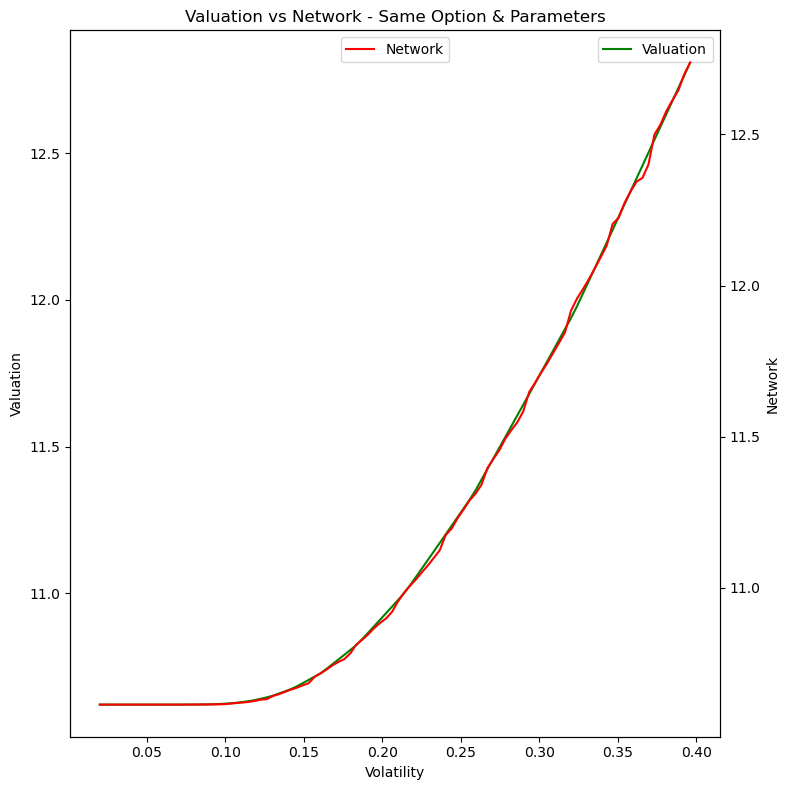

In [73]:
plot_dual_line(
    x=vols,
    y1=path_res,
    y2=cfrm_res,
    title="Valuation vs Network - Same Option & Parameters",
    x_lab="Volatility",
    y1_lab="Valuation",
    y2_lab="Network",

)

In [33]:
def two_d_scenario_ext(
    spot: Union[List[float], float],
    strike: Union[List[float], float],
    mat: Union[List[float], float],
    rate: Union[List[float], float],
    vol: Union[List[float], float],
    is_call: Union[List[float], float],
    is_american: Union[List[float], float],
    price_func: Callable,
    scaler=None,
) -> Tuple[List[float], str, List[float], str, np.ndarray]:
    """
    Generate a scenario where two of the given parameters are scenarios

    :param spot: spot scenario or single spot
    :param strike: strike scenario or single strike
    :param maturity: maturity scenario or single maturity
    :param rate: rate scenario or single rate
    :param vol: volatility scenario or single volatility
    :param is_call: True is option is a call
    :param is_american: true if option is american style with early exercise
    :param price_func: The pricing function, either black_scholes or model.predict
    :param scaler: The scaler used to normalize the model inputs
    :return: scenario List 1, scenario parameter 1 name, scenario List 2, scenario parameter 2 name, scenario prices

    """
    params = [spot, strike, mat, rate, vol, is_call, is_american]
    arg_names = [*inspect.signature(price_func).parameters.keys()]
    scenario_params = [
        [x[0][0], x[0][1], x[1]]
        for x in zip(enumerate(params), arg_names)
        if isinstance(x[0][1], List)
    ]
    assert (
        len(scenario_params) == 2
    ), "Only two parameters can be passed as scenario lists"
    prices = np.zeros((len(scenario_params[0][1]), len(scenario_params[1][1])))
    for i, x in enumerate(scenario_params[0][1]):
        params[scenario_params[0][0]] = x
        params[scenario_params[1][0]] = None
        param_set = np.tile(np.asarray(params),
                            (len(scenario_params[1][1]), 1))
        param_set[:, scenario_params[1][0]] = scenario_params[1][1]
        if scaler is not None:
            param_set = scaler.transform(param_set)
        if price_func.__name__ != "predict":
            param_set = param_set.transpose()
            prcs = (
                (price_func)(spots=param_set[0],
                             strikes=param_set[1],
                             expiries=param_set[2],
                             discount_rates=param_set[3],
                             volatilities=param_set[4],
                             is_call_options=param_set[5],
                             is_american=param_set[6]
                             )
            )
            prices[i, :] = prcs.numpy().reshape(1, len(scenario_params[1][1]))
        else:
            prices[i, :] = (
                (price_func)(param_set.astype(np.float64))
            ).reshape(1, len(scenario_params[1][1]))
        print(
            "{:0.0f} % Complete".format(
                100 * ((i * len(scenario_params[1][1])) / prices.size)
            )
        )
    print("Done")
    return (
        scenario_params[0][1],
        scenario_params[0][2],
        scenario_params[1][1],
        scenario_params[1][2],
        prices,
    )

In [23]:
# Scenario 2 : Maturity vs Vol Scenario
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario_ext(
    spot=60, strike=50, mat=mats, rate=0.025, vol=vols, is_call=True, is_american=True, price_func=option_price_binomial_w
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

In [84]:
s1, s1n, s2, s2n, predicted = two_d_scenario_ext(
    spot=60, strike=50, mat=mats, rate=0.025, vol=vols, is_call=True, is_american=True, price_func=model.predict
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

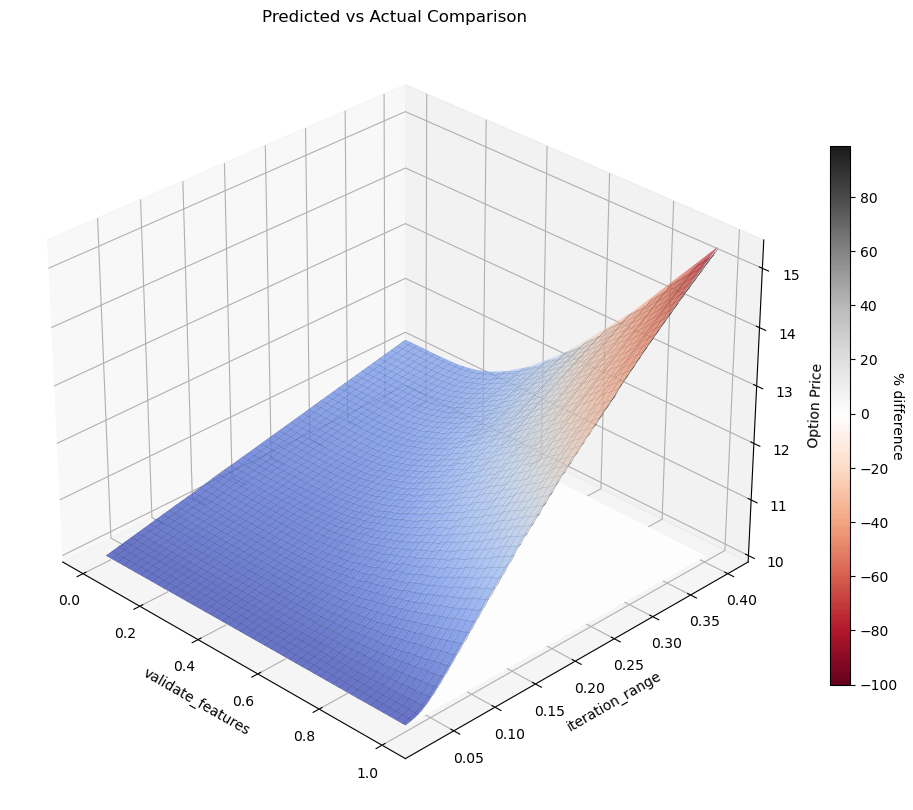

In [68]:
# Plot results from one of the last scenarios above that was run.
#
plot_price_surface(
    s1,
    s2,
    actual=actual,
    predicted=predicted,
    title="Predicted vs Actual Comparison",
    xscen_lab=s1n,
    yscen_lab=s2n,
)

In [35]:
X = Xd[0:50000000, :]
Y = Yd[0:50000000]
Xs, Ys = shuffle(X, Y, random_state=42)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.2)

In [130]:
regressor = xgb.XGBRegressor(eval_metric='rmsle')

In [52]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth":    [4, 5, 6, 10],
              "n_estimators": [500, 600, 700, 1000],
              "learning_rate": [0.01, 0.015, 0.02],
              'device': ["cuda"]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, Y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'device': 'cuda', 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1000}


In [54]:
param_grid = {"max_depth":    [10, 12, 15],
              "n_estimators": [1000, 1200, 1400, 1600],
              "learning_rate": [0.025, 0.03, 0.035],
              'device': ["cuda"]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, Y_train)
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'device': 'cuda', 'learning_rate': 0.035, 'max_depth': 15, 'n_estimators': 1400}


In [68]:
param_grid = {"max_depth":    [15, 17, 19],
              "n_estimators": [1400],
              "learning_rate": [0.035, 0.04, 0.045],
              'device': ["cuda"]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, Y_train)
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'device': 'cuda', 'learning_rate': 0.035, 'max_depth': 19, 'n_estimators': 1400}


In [175]:
param_grid = {"max_depth":    [10, 12, 15],
              "n_estimators": [1350],
              "gamma": [0.1, 0.5, 1.0, 1,5],
              "learning_rate": [0.034, 0.035, 0.036],
              'device': ["cuda"]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, Y_train)
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'device': 'cuda', 'gamma': 0.1, 'learning_rate': 0.034, 'max_depth': 15, 'n_estimators': 1350}


In [133]:
regressor = xgb.XGBRegressor(eval_metric='rmsle')
param_grid = {"max_depth":    [10],
              "n_estimators": [1350],
              "gamma": [0.1],
              "learning_rate": [0.034],
              "min_child_weight": [1, 3, 5, 10],
              'device': ["cuda"]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_trainClean, Y_trainClean)
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'device': 'cuda', 'gamma': 0.1, 'learning_rate': 0.034, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 1350}


In [135]:
regressor = xgb.XGBRegressor(learning_rate=0.034,
                             n_estimators=1350,
                             max_depth=10,
                             min_child_weight=3,
                             gamma=0.1,
                             device='cuda',
                             eval_metric='rmse',
                             verbosity=3)

In [38]:
#
# Remove outliers from the training data
#
yt = np.logical_or(Y_train > 100, np.isnan(Y_train))
yt = np.logical_or(yt, Y_train < 0)
Y_trainClean = np.array([y for y, t in zip(Y_train, yt) if not t])
X_trainClean = np.array([x for x, t in zip(X_train, yt) if not t])

In [39]:
print(len(X_trainClean))

39913929


In [66]:
#
# Remove outliers from the training data
#
ytt = np.logical_or(Y_test > 100, np.isnan(Y_test))
ytt = np.logical_or(ytt, Y_test < 0)
Y_testClean = np.array([y for y, t in zip(Y_test, ytt) if not t])
X_testClean = np.array([x for x, t in zip(X_test, ytt) if not t])
print(len(X_test))
print(len(X_testClean))

10000000
9978606


In [154]:
ypred = regressor.predict(X_testClean[:5000000])

In [155]:
print(np.max(np.abs(ypred - Y_testClean[:5000000]) ))

96.41110194299699


0.10971316474670277
96.41110194299699


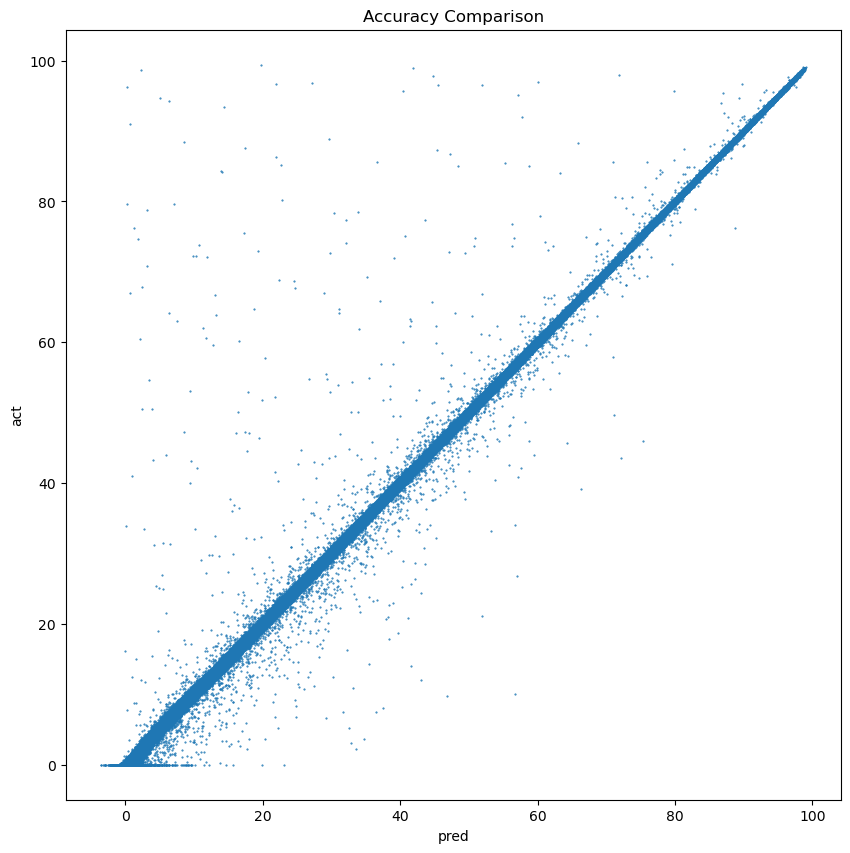

In [157]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ypred, Y_testClean[:5000000])
print(mse)
print(np.max(np.abs(ypred - Y_testClean[:5000000]) ))


plot_scatter(
    ypred,
    Y_testClean[:5000000],
    x_lab="pred",
    y_lab="act",
    title="Accuracy Comparison",
)

In [136]:
regressor.fit(X_trainClean, Y_trainClean)

[14:35:49] ======== Monitor (0): HostSketchContainer ========
[14:35:49] AllReduce: 0.007686s, 1 calls @ 7686us

[14:35:49] MakeCuts: 0.007872s, 1 calls @ 7872us

[14:35:49] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[14:35:49] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:744: [GPU Hist]: Configure
[14:35:51] ======== Monitor (0):  ========
[14:35:51] InitCompressedData: 0.010635s, 1 calls @ 10635us

[14:56:09] ======== Monitor (0): Learner ========
[14:56:09] Configure: 0.001104s, 1 calls @ 1104us

[14:56:09] EvalOneIter: 0.014917s, 1350 calls @ 14917us

[14:56:09] GetGradient: 72.1925s, 1350 calls @ 72192544us

[14:56:09] PredictRaw: 0.007387s, 1350 calls @ 7387us

[14:56:09] UpdateOneIter: 1218.62s, 1350 calls @ 1218621838us

[14:56:09] ======== Monitor (0):

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.034, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [137]:
regressor.save_model('xgb_regressor.json')

In [42]:
# Scenario 2 : Maturity vs Vol Scenario
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=100)
s1, s1n, s2, s2n, actual = two_d_scenario_ext(
    spot=30, strike=strikes, mat=1.0, rate=0.025, vol=vols, is_call=True, is_american=False, price_func=option_price_binomial_w
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

In [138]:
s1, s1n, s2, s2n, predicted = two_d_scenario_ext(
    spot=30, strike=strikes, mat=1.0, rate=0.025, vol=vols, is_call=True, is_american=False, price_func=regressor.predict
)

0 % Complete
1 % Complete
2 % Complete
3 % Complete
4 % Complete
5 % Complete
6 % Complete
7 % Complete
8 % Complete
9 % Complete
10 % Complete
11 % Complete
12 % Complete
13 % Complete
14 % Complete
15 % Complete
16 % Complete
17 % Complete
18 % Complete
19 % Complete
20 % Complete
21 % Complete
22 % Complete
23 % Complete
24 % Complete
25 % Complete
26 % Complete
27 % Complete
28 % Complete
29 % Complete
30 % Complete
31 % Complete
32 % Complete
33 % Complete
34 % Complete
35 % Complete
36 % Complete
37 % Complete
38 % Complete
39 % Complete
40 % Complete
41 % Complete
42 % Complete
43 % Complete
44 % Complete
45 % Complete
46 % Complete
47 % Complete
48 % Complete
49 % Complete
50 % Complete
51 % Complete
52 % Complete
53 % Complete
54 % Complete
55 % Complete
56 % Complete
57 % Complete
58 % Complete
59 % Complete
60 % Complete
61 % Complete
62 % Complete
63 % Complete
64 % Complete
65 % Complete
66 % Complete
67 % Complete
68 % Complete
69 % Complete
70 % Complete
71 % Complete
72

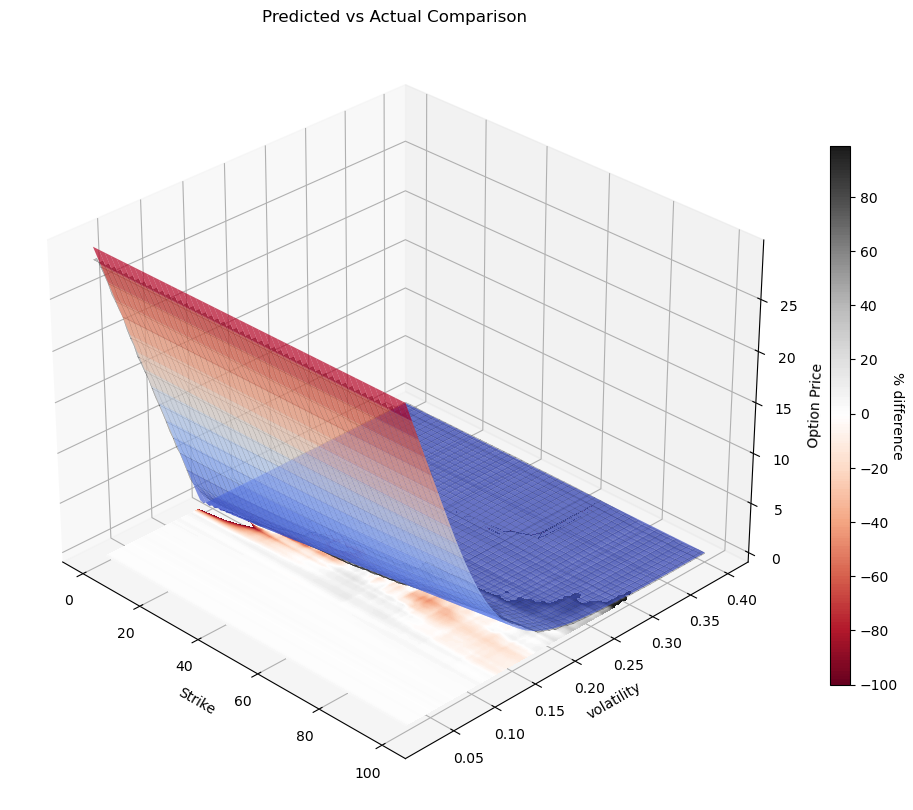

In [139]:
# Plot results from one of the last scenarios above that was run.
#
plot_price_surface(
    s1,
    s2,
    actual=actual,
    predicted=predicted,
    title="Predicted vs Actual Comparison",
    xscen_lab="Strike",
    yscen_lab="volatility",
)

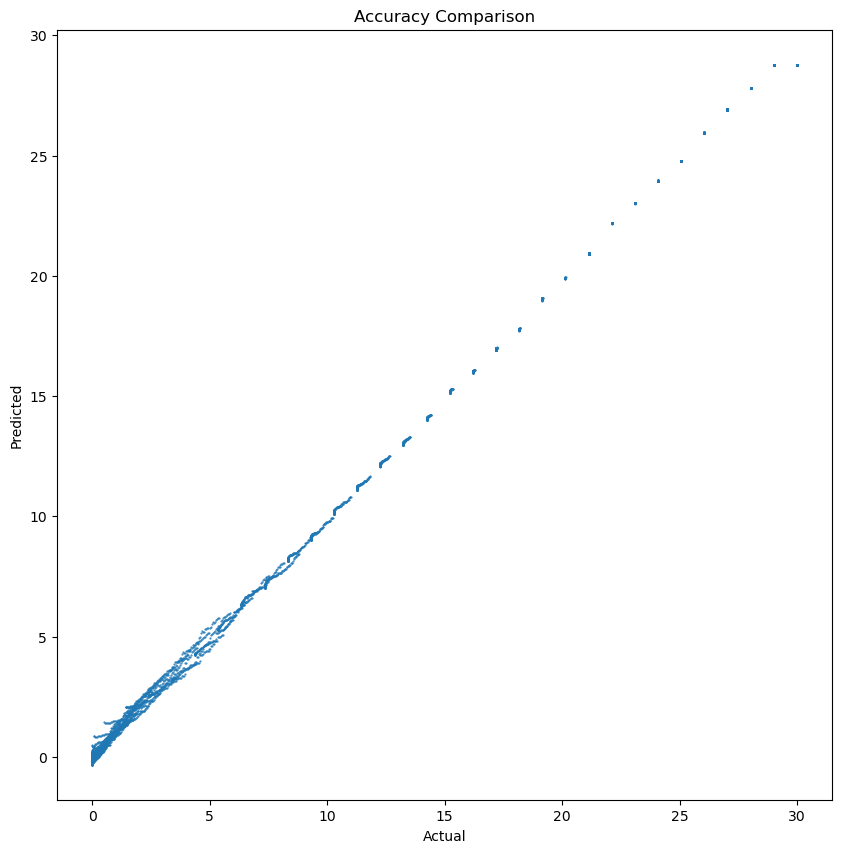

In [140]:

plot_scatter(
    actual.flatten(),
    predicted.flatten(),
    x_lab="Actual",
    y_lab="Predicted",
    title="Accuracy Comparison",
)

In [45]:
def numerical_delta(model,
                    k: float = STRIKE,
                    spot_min: float = 1,
                    spot_max: float = 100) -> None:
    """
    Calculate the numerical delta for the given model.

    Args:
        model: The model to use calculating delta
        k (float): The strike price.
        spot_min (float): The minimum spot price.
        spot_max (float): The maximum spot price.

    Returns:
        the numerical_deltas for the spot range
    """
    is_call = 1
    is_american = 1

    numerical_deltas = []
    small_change: Final[float] = 1e-6

    # Spot range must be within the trained range
    step_size = 10 # 0.25
    spots = [x * step_size for x in range(spot_min, int(spot_max / step_size))]
    print(spots)
    x_p1 = np.zeros((len(spots), 7))
    x_p2 = np.zeros((len(spots), 7))

    for i, spot in enumerate(spots, 0):
        # Build up the scenarios to make batch calls to model predict outside of this loop.
        x_p1[i] = [spot, k, MAT, RATE, VOL, is_call, is_american]
        x_p2[i] = [spot + small_change, k, MAT, RATE, VOL, is_call, is_american]
        print(model.predict([x_p1[i]]))
        print(model.predict([x_p2[i]]))
    # Predict as batches
    p1 = model.predict(x_p1)
    p2 = model.predict(x_p2)

    # Numerical delta is diff in price over spot increment
    numerical_deltas = ((p2-p1)/small_change).tolist()

    return numerical_deltas

In [117]:
ND = numerical_delta(regressor, k=50, spot_min=1, spot_max=100)

[10, 20, 30, 40, 50, 60, 70, 80, 90]
[0.02473]
[0.02473]
[0.04700]
[0.04700]
[-0.07674]
[-0.07674]
[-0.04923]
[-0.04923]
[3.37069]
[3.37069]
[11.32295]
[11.32295]
[20.70383]
[20.70383]
[30.61240]
[30.61240]
[40.76429]
[40.76429]


In [118]:
inc = 0
dl_array = []
s_array=[]
for q in range(200):
    inc += .5
    vls = [ 1+inc, 50.0, 1, 0.05, .25, 1, 0]
    vlse = [1+inc+0.05, 50.0, 1, 0.05, .25, 1, 0]
    dl = regressor.predict(np.asarray(vls).astype(np.float64).reshape(1, 7))
    dle = regressor.predict(np.asarray(vlse).astype(np.float64).reshape(1, 7))
    print(1+inc,dle,dl)
    if (dl) > 0:
            dl_array.append(dl)
            s_array.append(1+inc)

1.5 [-0.01352] [-0.01352]
2.0 [-0.01854] [-0.01854]
2.5 [-0.01698] [-0.01698]
3.0 [-0.01740] [-0.01740]
3.5 [-0.01604] [-0.01557]
4.0 [-0.01054] [-0.01054]
4.5 [-0.01389] [-0.01389]
5.0 [-0.01389] [-0.01389]
5.5 [-0.01299] [-0.01299]
6.0 [-0.01126] [-0.01126]
6.5 [-0.01066] [-0.01066]
7.0 [-0.00343] [-0.00338]
7.5 [-0.00501] [-0.00501]
8.0 [-0.00681] [-0.00681]
8.5 [-0.00691] [-0.00691]
9.0 [-0.00462] [-0.00462]
9.5 [-0.00540] [-0.00540]
10.0 [-0.00788] [-0.00788]
10.5 [-0.00762] [-0.00762]
11.0 [-0.00748] [-0.00748]
11.5 [-0.01293] [-0.01293]
12.0 [-0.01249] [-0.01249]
12.5 [-0.01993] [-0.01202]
13.0 [-0.02089] [-0.02089]
13.5 [-0.02070] [-0.02070]
14.0 [-0.02343] [-0.02343]
14.5 [-0.02621] [-0.02621]
15.0 [-0.02879] [-0.02879]
15.5 [-0.02953] [-0.02953]
16.0 [-0.02798] [-0.02891]
16.5 [-0.02949] [-0.02949]
17.0 [-0.02988] [-0.02988]
17.5 [-0.02981] [-0.02981]
18.0 [-0.02978] [-0.02978]
18.5 [-0.02854] [-0.02854]
19.0 [-0.02122] [-0.02122]
19.5 [-0.01743] [-0.01835]
20.0 [-0.01193] [-

In [63]:
print(dl_array)

[array([0.00009], dtype=float32), array([0.00009], dtype=float32), array([0.00009], dtype=float32), array([0.00009], dtype=float32), array([0.00007], dtype=float32), array([0.00007], dtype=float32), array([0.00007], dtype=float32), array([0.00004], dtype=float32), array([0.00001], dtype=float32), array([0.00031], dtype=float32), array([0.00049], dtype=float32), array([0.00037], dtype=float32), array([0.00049], dtype=float32), array([0.00019], dtype=float32), array([0.01930], dtype=float32), array([0.05643], dtype=float32), array([0.10884], dtype=float32), array([0.10731], dtype=float32), array([0.10452], dtype=float32), array([0.11579], dtype=float32), array([0.12523], dtype=float32), array([0.12627], dtype=float32), array([0.16336], dtype=float32), array([0.21598], dtype=float32), array([0.24953], dtype=float32), array([0.29281], dtype=float32), array([0.29507], dtype=float32), array([0.34214], dtype=float32), array([0.35261], dtype=float32), array([0.36653], dtype=float32), array([0.

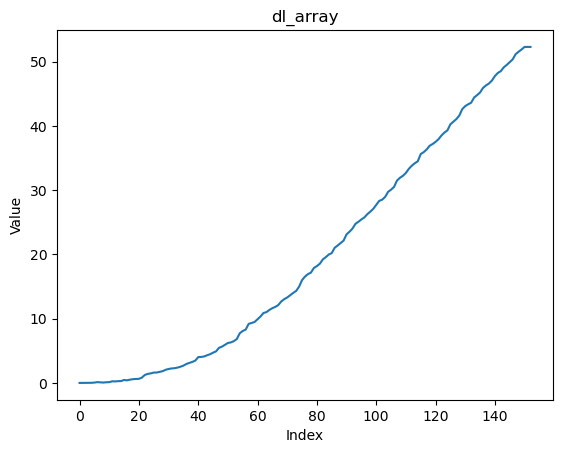

In [119]:

plt.plot(dl_array)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('dl_array')
plt.show()



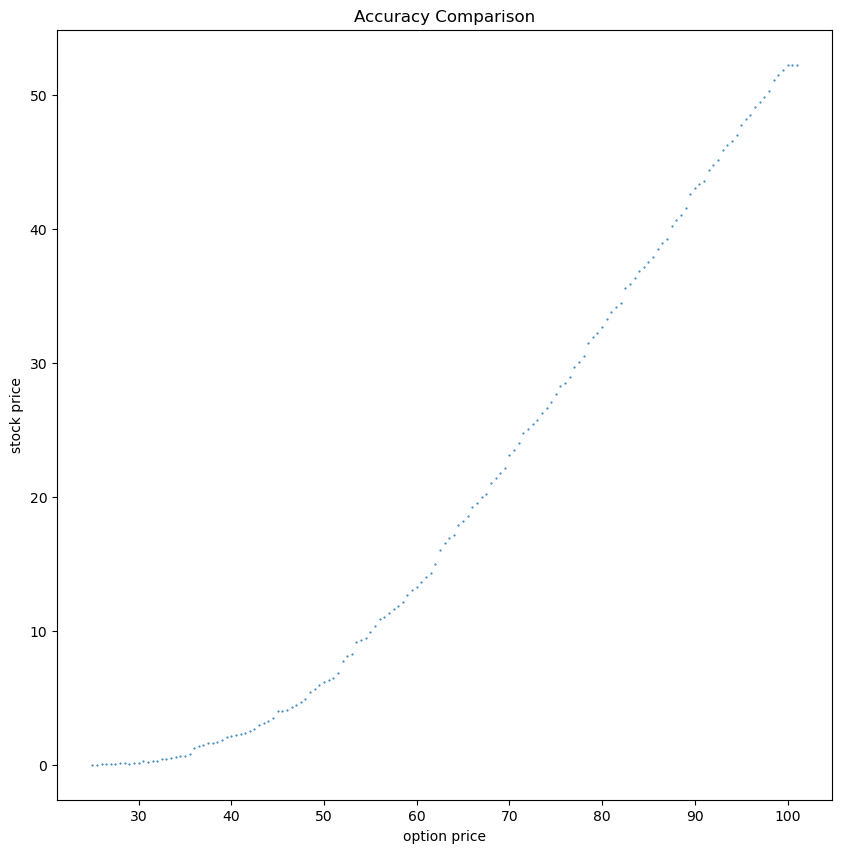

In [123]:

plot_scatter(
    np.array(s_array),
    np.array(dl_array),
    x_lab="stock price",
    y_lab="option price",
    title="Accuracy Comparison",
)

In [93]:
xk = X_trainClean[:10000]
yk = Y_testClean[:10000]
xyk = np.column_stack((xk, yk))


In [ ]:
model = XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)